<a href="https://colab.research.google.com/github/MoonJaeHoon/dacon_parking_demand/blob/master/Data_PreProcessing1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

- 결측치 모두 ML Model로 채워줌
    * '-'는 0으로 채워줬음
> 연속형은 0으로 채우고, 범주형은 빈도수 체크해서 채우는게 국룰인듯하여 시도해봐야할듯

- 주요연령대에 대해서만 F.E. 진행
    - 너무 많은 변수를 생성하였음. (쫌 줄여보기)
    - 주요연령대의 인구비율만 나오고, 실제 인구수는 없음
    
> - 공공데이터 구하면 실제 연령대별 인구수까지 활용할 수 있을 것 같으니 시도해보기
> - 실제 연령대별 차량 보유 현황도 공공데이터가 있지 않나? 가져와서 시도해보기

In [ ]:
## Plot 한글
# Step 1. Matplotlib 업그레이드
!pip install matplotlib -U

# Step 2. 한글 설치 및 사용 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# Step 3. 런타임 재시작

In [ ]:
!pip install pycaret[full] ngboost shap

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm, tqdm_notebook
# Step 4. 한글 글꼴 설정
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import  pprint
import warnings
warnings.filterwarnings('ignore')
from pycaret.classification import *
from pycaret.regression import *
from pycaret.utils import check_metric
import os
import pickle

plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
seed=47
def set_seed(seed: int = 42, contain_cuda: bool = False):
    random.seed(seed)
    np.random.seed(seed)

    # if contain_cuda:
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False

    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    print(f"Seed set as {seed}")
set_seed(seed)

Seed set as 47


In [8]:
cd drive/MyDrive/dacon_parking_data

/content/drive/MyDrive/dacon_parking_data


In [9]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
age_gender_info = pd.read_csv('./data/age_gender_info.csv')
submission = pd.read_csv('./data/sample_submission.csv')
print(f"train.shape : {train.shape}")
print(f"test.shape : {test.shape}")

# print(f"len(train.columns) : {len(train.columns)}")
# print(f"len(test.columns) : {len(test.columns)}")

train.shape : (2952, 15)
test.shape : (1022, 14)


In [10]:
print(f"len(set(train.단지코드)) : {len(set(train.단지코드))}")
print(f"len(set(train.공급유형)) : {len(set(train.공급유형))}")
train.tail(5)

len(set(train.단지코드)) : 423
len(set(train.공급유형)) : 10


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2951,C2532,239,아파트,강원도,국민임대,54.95,19,7.0,A,14830000,151030,0.0,1.0,166.0,146.0


## age_gender_info DataSet

In [11]:
print(f"age_gender_info.shape : {age_gender_info.shape}")
age_gender_info.sample(5)

age_gender_info.shape : (16, 23)


,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
14,서울특별시,0.015323,0.015627,0.025210,0.026121,0.052712,0.056782,0.047655,0.051877,0.054216,0.068673,0.077163,0.064801,0.119639,0.078939,0.097543,0.061050,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
11,충청북도,0.034678,0.035339,0.059808,0.061570,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010


# Train & Test Set

In [12]:
# 하나의 단지코드당 하나의 Output 결과값만이 도출되어야 한다.
# 따라서 EDA시, 단지코드 별로 agg가 필요함.

In [13]:
# train과 test 간에 단지코드가 겹치는 경우는 없다.
print(set(train.단지코드) & set(test.단지코드))

set()


In [14]:
cat_features = [col for col in train.columns if train[col].dtype=='O']
for c in cat_features:
    exist_test_but_not_train = set(test[c])-set(train[c])
    if len(exist_test_but_not_train)>=1:
        print(f"'{c}' 변수 \t exist_test_but_not_train : {len(exist_test_but_not_train)}")

'단지코드' 변수 	 exist_test_but_not_train : 150
'자격유형' 변수 	 exist_test_but_not_train : 1
'임대보증금' 변수 	 exist_test_but_not_train : 280
'임대료' 변수 	 exist_test_but_not_train : 283


## 0.결측치 확인

In [15]:
print('=====train 내부 결측치 Column 확인=====')
check_nan_dict = train.isnull().sum().to_dict()
pprint({k:v for k,v in check_nan_dict.items() if v!=0})

print('=====test 내부 결측치 Column 확인=====')
check_nan_dict = test.isnull().sum().to_dict()
pprint({k:v for k,v in check_nan_dict.items() if v!=0})

=====train 내부 결측치 Column 확인=====
{'도보 10분거리 내 버스정류장 수': 4,
 '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 211,
 '임대료': 569,
 '임대보증금': 569}
=====test 내부 결측치 Column 확인=====
{'도보 10분거리 내 지하철역 수(환승노선 수 반영)': 42, '임대료': 180, '임대보증금': 180, '자격유형': 2}


### 0.1 자격유형 변수 결측치
> Test Set의 `자격유형` 변수부터 결측치를 채울 수 있도록 해보자.

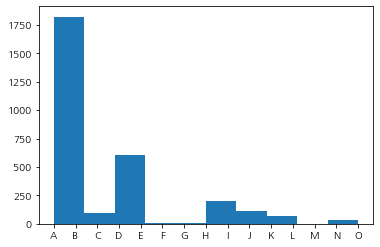

In [16]:
plt.hist(train['자격유형'])
plt.show()

In [17]:
for t in train.자격유형.unique():
    print(t, train.loc[train.자격유형==t,'공급유형'].value_counts().to_dict())

A {'국민임대': 1539, '공공임대(10년)': 205, '공공임대(50년)': 31, '공공임대(분납)': 12, '장기전세': 9, '공공임대(5년)': 3, '영구임대': 2}
B {'국민임대': 21}
C {'영구임대': 95}
D {'임대상가': 562, '공공분양': 7}
E {'국민임대': 34, '영구임대': 3}
F {'영구임대': 3}
G {'국민임대': 9}
H {'국민임대': 155}
I {'영구임대': 49}
J {'행복주택': 114}
K {'행복주택': 33}
L {'행복주택': 33}
M {'행복주택': 2}
N {'행복주택': 30}
O {'행복주택': 1}


In [18]:
for t in test.자격유형.unique():
    print(t, test.loc[test.자격유형==t,'공급유형'].value_counts().to_dict())

H {'국민임대': 92}
A {'국민임대': 518, '공공임대(10년)': 35, '공공임대(50년)': 13, '공공임대(분납)': 6}
E {'국민임대': 10}
C {'영구임대': 34}
D {'임대상가': 177, '영구임대': 3}
nan {}
G {'국민임대': 1}
I {'영구임대': 7}
J {'행복주택': 84}
K {'행복주택': 16}
L {'행복주택': 12}
M {'행복주택': 2}
N {'행복주택': 10}


In [19]:
train.자격유형.value_counts()

A    1801
D     569
H     155
J     114
C      95
I      49
E      37
L      33
K      33
N      30
B      21
G       9
F       3
M       2
O       1
Name: 자격유형, dtype: int64

In [20]:
# train.loc[train.단지코드=='C2040',:]
# train.loc[train.지역=='제주특별자치도',:]
train.loc[(train.자격유형=='E') & (train.공급유형=='영구임대'),:]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
178,C1616,1507,아파트,대전광역시,영구임대,40.32,450,1.0,E,54040000,28140,NaN,2.0,407.0,98.0
2053,C2255,560,아파트,충청남도,영구임대,23.93,34,2.0,E,31980200,16650,0.0,2.0,400.0,410.0
2415,C2539,396,아파트,충청남도,영구임대,26.81,58,8.0,E,45995000,23950,0.0,2.0,237.0,228.0


In [21]:
train.loc[(train.자격유형=='E') & (train.공급유형!='영구임대'),:].임대보증금.min()

'114953000'

In [22]:
train.loc[(train.자격유형=='E') & (train.공급유형=='영구임대'),:].임대보증금.max()

'54040000'

In [23]:
print(set(train.loc[(train.자격유형=='E') & (train.공급유형=='영구임대'),:].단지코드) & set(train.loc[(train.자격유형=='E') & (train.공급유형!='영구임대'),:].단지코드))

set()


In [24]:
# 단지코드와 공급유형별로 나누어도 '자격유형'이 Unique하지 않음 
# 단지코드와 공급유형 변수만으론 '자격유형'의 결측치를 채울 수가 없음.
result = []
for i in train.단지코드.unique():
    for j in train.공급유형.unique():
        length = len(set(train.loc[(train.단지코드==i)&(train.공급유형==j),'자격유형']))
        if length > 1:
            result.append({i:length})
print(result)

[{'C1616': 2}, {'C2132': 2}, {'C2401': 2}, {'C2538': 3}, {'C2097': 2}, {'C2361': 2}, {'C2458': 2}, {'C2394': 2}, {'C2488': 2}, {'C2460': 2}, {'C1572': 2}, {'C1316': 2}, {'C1328': 2}, {'C2357': 3}, {'C2255': 2}, {'C2137': 2}, {'C1136': 2}, {'C2393': 2}, {'C2507': 2}, {'C1685': 2}, {'C2618': 2}, {'C1451': 2}, {'C1659': 3}, {'C1786': 2}]


In [25]:
train.임대보증금

0       15667000
1       15667000
2       27304000
3       27304000
4       27304000
          ...   
2947    11346000
2948    14005000
2949    14005000
2950    14005000
2951    14830000
Name: 임대보증금, Length: 2952, dtype: object

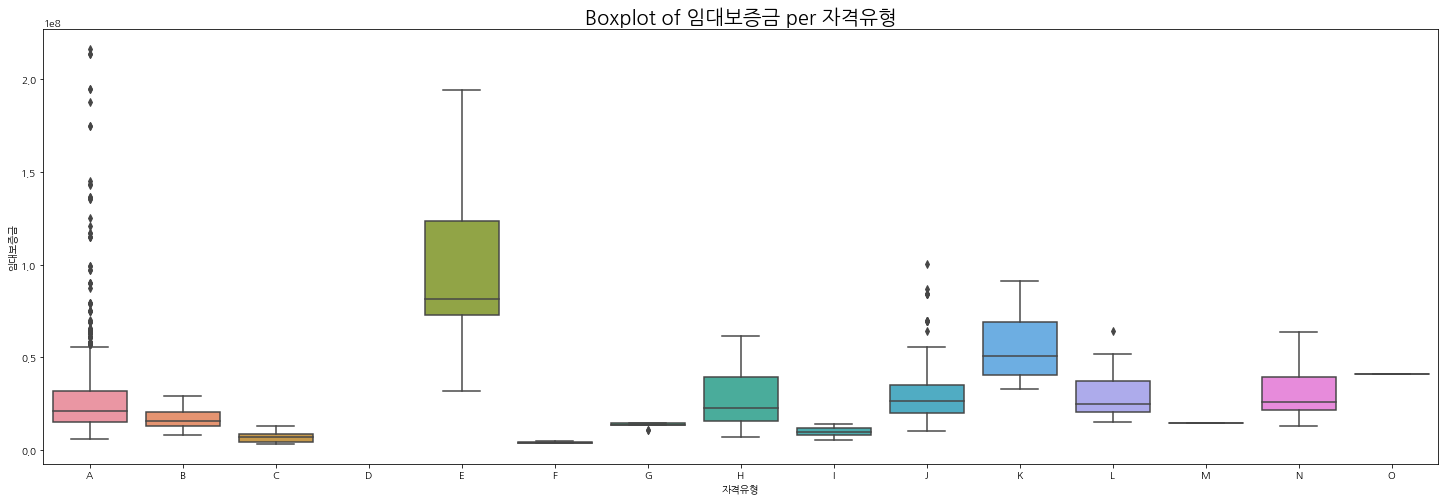

In [26]:
# '자격유형'과 '임대보증금' 간의 관계 BoxPlot 시각화
# '공급유형' 범주까지도 또한 나누어서 확인해보았음
copy_train = train.copy()
copy_train = copy_train.loc[copy_train.임대보증금!='-',:]
copy_train.임대보증금 = copy_train.임대보증금.astype(float)

plt.figure(figsize=(25,8))
import seaborn as sns
sns.boxplot(x="자격유형", 
            y="임대보증금", 
            # hue="공급유형",   # 자격유형을 공급유형별로 한번더 범주를 나눠서 시각화해볼 수 있음.
            data=copy_train)
plt.title("Boxplot of 임대보증금 per 자격유형",fontdict={'fontsize':20})
plt.show()


In [27]:
train.loc[train.자격유형=='I','공급유형'].value_counts()

영구임대    49
Name: 공급유형, dtype: int64

In [28]:
train.loc[train.자격유형=='H','공급유형'].value_counts()

국민임대    155
Name: 공급유형, dtype: int64

> 결론적으로, `단지코드`,`공급유형`,`임대보증금` 모두 이용하더라도 아래 Test Set 변수 `자격유형` 내 결측치를 채울 수가 없음

In [29]:
test.loc[test.자격유형.isnull(),:]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [30]:
test.loc[(test.자격유형=='D') & (test.공급유형=='영구임대'),:]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,NaN,NaN,2.0,5.0,428.0


> 그럼 결측치를 적절하게 채울 수 있는 방법엔 무엇이 있을까?
1. 최빈값, 평균값 등 대표값으로 채워주기
2. 결측치가 존재하는 변수를 타겟 변수로 삼고 간단한 모델 fitting

In [31]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [32]:
# 결측치 채워야할 row들 추출
nan_test = test.loc[test.자격유형.isnull(),:]
nan_test

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


100%|██████████| 3/3 [00:00<00:00, 151.86it/s]


임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
accuracy_score : 1.0


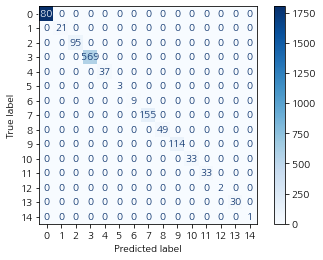

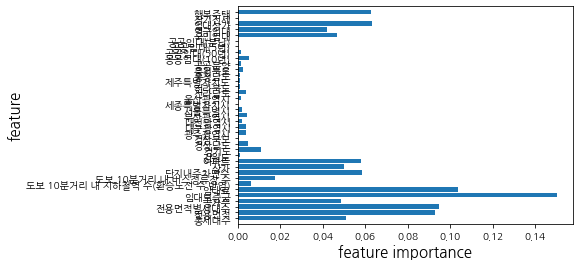

In [33]:
# RandomForest로 `자격유형` 변수의 결측치를 한번 채워보자

def process_for_imputation_modleing(df,df_test,is_train=True):
    if '등록차량수' in df.columns:
        df = df.drop(['등록차량수'],axis=1)
    
    df['belongs'] = 'train'
    df_test['belongs'] = 'test'
    df = pd.concat([df,df_test],axis=0)
    df.index = range(df.shape[0])

    preprocessed_df = df.copy().drop(['단지코드'],axis=1)

    preprocessed_df = preprocessed_df.fillna(-999)
    preprocessed_df = preprocessed_df.replace('-',-999)


    preprocessed_df[['임대보증금', '임대료']] = preprocessed_df[['임대보증금', '임대료']].astype('float')
    dict_for_encoding_label = {value:num_idx for num_idx,value in enumerate(preprocessed_df['자격유형'].unique())}
    preprocessed_df['자격유형'] = preprocessed_df['자격유형'].map(dict_for_encoding_label)
    dict_for_decoding_label = {v:k for k,v in dict_for_encoding_label.items()}

    cat_features = [col for col in preprocessed_df.columns if (preprocessed_df[col].dtype=='O') & (not col=='belongs')]
    
    for c in tqdm(cat_features):
        dummy_df_for_cat = pd.get_dummies(preprocessed_df[c])
        print(f"{c} 변수 더미차원추가 : {dummy_df_for_cat.shape[1]}")
        preprocessed_df = pd.concat([preprocessed_df,dummy_df_for_cat],axis=1).drop([c],axis=1)
        # dict_for_encoding_str = {value:num_idx for num_idx,value in enumerate(preprocessed_df[c].unique())}
        # preprocessed_df[c] = preprocessed_df[c].map(dict_for_encoding_str)

    preprocessed_df_test = preprocessed_df.loc[preprocessed_df['belongs']=="test",:].drop(['belongs'],axis=1)
    preprocessed_df_test.index = range(preprocessed_df_test.shape[0])

    preprocessed_df = preprocessed_df.loc[preprocessed_df['belongs']=="train",:].drop(['belongs'],axis=1)
    return preprocessed_df, preprocessed_df_test, dict_for_decoding_label

preprocessed_train, preprocessed_df_test, tr_dict_for_decoding_label = process_for_imputation_modleing(train, nan_test)

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

rf_for_imputation = RandomForestClassifier(n_estimators=500,random_state=seed)
train_x = preprocessed_train.drop(['자격유형'],axis=1)
train_y = preprocessed_train['자격유형']
rf_for_imputation.fit(train_x,train_y)
predict_result = rf_for_imputation.predict(train_x)
print('='*50)
print(f"accuracy_score : {accuracy_score(train_y,predict_result)}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
plot_confusion_matrix(estimator=rf_for_imputation, 
                      X=train_x, 
                      y_true=train_y,
                      cmap=plt.cm.Blues,
                      )
plt.show()
print('='*50)
## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.barh(index, rf_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)
plt.show()

In [34]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [35]:
# preprocessed_df, preprocessed_df_test, dict_for_decoding_label = process_for_imputation_modleing(train, nan_test, is_train=False)
print(preprocessed_df_test.shape)

imput_val_by_model = rf_for_imputation.predict(preprocessed_df_test.drop(['자격유형'],axis=1))
imput_val_by_model = pd.Series(imput_val_by_model)
imput_val_by_model = imput_val_by_model.map(tr_dict_for_decoding_label).to_list()
imput_val_by_model

(2, 38)


['E', 'C']

In [36]:
test.loc[test['자격유형'].isnull(),'자격유형'] = imput_val_by_model
test['자격유형'].isnull().sum()

0

In [37]:
train.loc[train.공급유형=='국민임대','자격유형'].value_counts()

A    1539
H     155
E      34
B      21
G       9
Name: 자격유형, dtype: int64

In [38]:
train.loc[train.공급유형=='영구임대','자격유형'].value_counts()

C    95
I    49
F     3
E     3
A     2
Name: 자격유형, dtype: int64

In [39]:
# 결측치를 -999로 채워서 모델을 fit하면
## test set의 자격유형 변수 결측치 (2개) 'E','C'로 채움

## test set의 자격유형 변수 결측치 (2개) 다른 노트북에서는 A & C로 채움

### 0.2 도보 10분거리 내 버스정류장 수 결측치

train에만 결측치 존재, test에는 결측치 X

※ 혹시 단지코드와 버스정류장 수 사이에 관계가 있을까?
- 없음, C1649 라는 단지코드 데이터에는 `도보 10분거리 내 버스정류장 수` 변수가 모두 결측치임

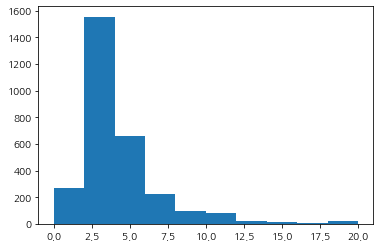

In [40]:
plt.hist(train['도보 10분거리 내 버스정류장 수'])
plt.show()

C1649라는 하나의 단지에만 결측치들이 존재하고 있음

In [41]:
all(train.loc[train.단지코드=='C1649',:].index == train.loc[train["도보 10분거리 내 버스정류장 수"].isnull(),:].index)

True

In [42]:
# 결측치 채워야할 row들 추출
nan_train = train.loc[train["도보 10분거리 내 버스정류장 수"].isnull(),:]
nan_train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2315,C1649,575,아파트,경상남도,공공임대(10년),74.97,80,15.0,A,46000000,456000,NaN,NaN,1066.0,855.0
2316,C1649,575,아파트,경상남도,공공임대(10년),84.95,124,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0
2317,C1649,575,아파트,경상남도,공공임대(10년),84.96,289,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0
2318,C1649,575,아파트,경상남도,공공임대(10년),84.98,82,15.0,A,57000000,462000,NaN,NaN,1066.0,855.0


100%|██████████| 4/4 [00:00<00:00, 133.49it/s]


임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train.shape : (2948, 53)
Model Name : LGBMRegressor
accuracy_score : 0.9969470827679783
mean_absolute_error : 0.048671697172943396 & mean_squared_error(root) : 0.08295319352589237
    0    1    2    3    4    5    6   7   8   9   10  11  12  13  14  15  16  \
0    1    1    0    0    0    0    0   0   0   0   0   0   0   0   0   0   0   
1    0  270    0    0    0    0    0   0   0   0   0   0   0   0   0   0   0   
2    0    0  780    0    0    0    0   0   0   0   0   0   0   0   0   0   0   
3    0    0    0  776    0    0    0   0   0   0   0   0   0   0   0   0   0   
4    0    0    0    0  493    0    0   0   0   0   0   0   0   0   0   0   0   
5    0    0    0    0    0  164    0   0   0   0   0   0   0   0   0   0   0   
6    0    0    0    0    0    1  155   0   0   0   0   0   0   0   0   0   0   
7    0    0    0    0    0    0    0  65   0   0   0   0   0   0   0   0   0   
8    0  

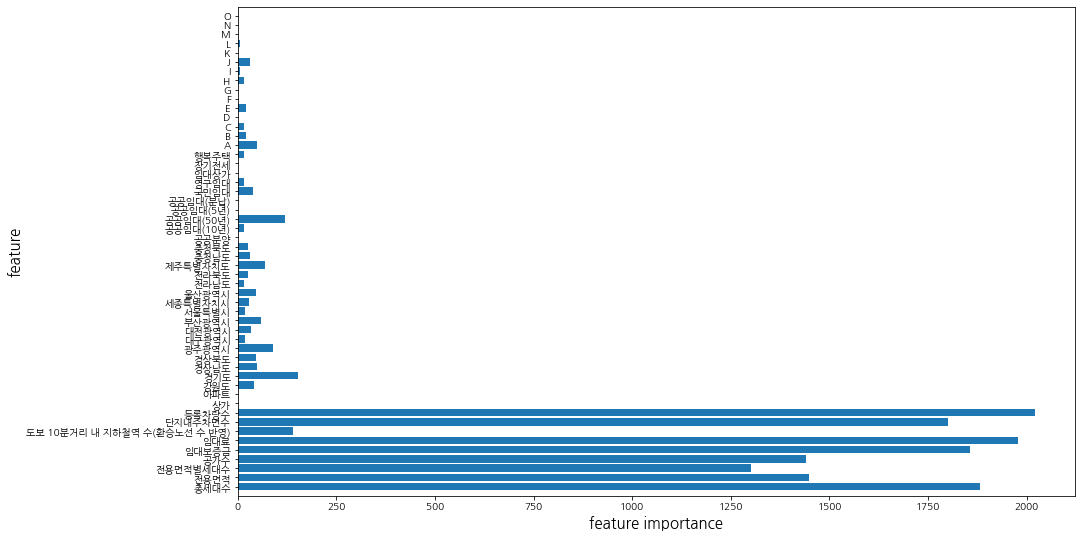

In [43]:
# RandomForest로 `도보 10분거리 내 버스정류장 수` 변수의 결측치를 한번 채워보자

def process_for_imputation_modleing2(df, get_nan_data=False):
    # if '등록차량수' in df.columns:
    #     df = df.drop(['등록차량수'],axis=1)
    
    preprocessed_df = df.copy().drop(['단지코드'],axis=1)
    preprocessed_df['nan_in_target'] = False
    preprocessed_df.loc[preprocessed_df['도보 10분거리 내 버스정류장 수'].isnull(),"nan_in_target"] = True

    preprocessed_df = preprocessed_df.fillna(-999)
    preprocessed_df = preprocessed_df.replace('-',-999)
    preprocessed_df[['임대보증금', '임대료']] = preprocessed_df[['임대보증금', '임대료']].astype('float')

    cat_features = [col for col in preprocessed_df.columns if (preprocessed_df[col].dtype=='O') & (not col=='belongs')]

    for c in tqdm(cat_features):
        dummy_df_for_cat = pd.get_dummies(preprocessed_df[c])
        print(f"{c} 변수 더미차원추가 : {dummy_df_for_cat.shape[1]}")
        preprocessed_df = pd.concat([preprocessed_df,dummy_df_for_cat],axis=1).drop([c],axis=1)
    
    if get_nan_data:
        preprocessed_df = preprocessed_df.loc[preprocessed_df["nan_in_target"]==True,:].drop(["nan_in_target"],axis=1)
    else:
        preprocessed_df = preprocessed_df.loc[preprocessed_df["nan_in_target"]==False,:].drop(["nan_in_target"],axis=1)


    return preprocessed_df

preprocessed_train = process_for_imputation_modleing2(train,get_nan_data=False)
print(f"preprocessed_train.shape : {preprocessed_train.shape}")
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error # 정확도 함수
train_x = preprocessed_train.drop(['도보 10분거리 내 버스정류장 수'],axis=1)
train_y = preprocessed_train['도보 10분거리 내 버스정류장 수']

# RF
# model_for_imputation = RandomForestRegressor(n_estimators=500,random_state=seed)
# LGBM
model_for_imputation = LGBMRegressor(n_estimators=500,random_state=seed)


model_for_imputation.fit(train_x,train_y)

predict_result = model_for_imputation.predict(train_x)
print('='*50)
model_name = str(model_for_imputation)
print(f"Model Name : {model_name[:model_name.index('(')]}")
print(f"accuracy_score : {accuracy_score(train_y,np.round(predict_result))}")
print(f"mean_absolute_error : {mean_absolute_error(train_y,predict_result)} & mean_squared_error(root) : {mean_squared_error(train_y,predict_result)**0.5}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
cfm = confusion_matrix(y_true=train_y, y_pred=np.round(predict_result))
cfm = pd.DataFrame(cfm, index=range(cfm.shape[0]),columns=range(cfm.shape[0]))
print(cfm)
print('='*50)
## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.figure(figsize=(15,9))
plt.barh(index, model_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

# Model Name : RandomForestRegressor
# accuracy_score : 0.9525101763907734
# mean_absolute_error : 0.1206838534599728 & mean_squared_error(root) : 0.2751251300367664

## '등록차량수'도 추가하여 RandomForestRegressor fitting
# accuracy_score : 0.9694708276797829
# mean_absolute_error : 0.09246879240162817 & mean_squared_error(root) : 0.2190241617867863

# Model Name : LGBMRegressor
# accuracy_score : 0.9969470827679783
# mean_absolute_error : 0.06591848599078357 & mean_squared_error(root) : 0.10525635774034212

## '등록차량수'도 추가하여 LGBMRegressor fitting
# accuracy_score : 0.9969470827679783
# mean_absolute_error : 0.048671697172943396 & mean_squared_error(root) : 0.08295319352589237


In [44]:
train_y.describe()

count    2948.000000
mean        3.695726
std         2.644665
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        20.000000
Name: 도보 10분거리 내 버스정류장 수, dtype: float64

In [45]:
preprocessed_train_nan = process_for_imputation_modleing2(train,get_nan_data=True)
print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
imput_val_by_model = np.round(model_for_imputation.predict(preprocessed_train_nan.drop(['도보 10분거리 내 버스정류장 수'],axis=1)))
print(imput_val_by_model)
train.loc[train['도보 10분거리 내 버스정류장 수'].isnull(),'도보 10분거리 내 버스정류장 수'] = imput_val_by_model
train['도보 10분거리 내 버스정류장 수'].isnull().sum()

100%|██████████| 4/4 [00:00<00:00, 193.12it/s]

임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train_nan.shape : (4, 53)
[3. 3. 3. 3.]


0

### 0.3 도보 10분거리 내 지하철역 수(환승노선 수 반영) 결측치

※ 혹시 단지코드와 지하철역 수 사이에 관계가 있을까?
- 이번에도 없음, 아래 확인

In [46]:
unique_danji_codes = train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull(),'단지코드'].unique()
for U in unique_danji_codes:
    idxes = train.loc[train['단지코드'] == U,'도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts(dropna=False).index
    print(f"{U} : {idxes}")


C1312 : Float64Index([nan], dtype='float64')
C1874 : Float64Index([nan], dtype='float64')
C1424 : Float64Index([nan], dtype='float64')
C2100 : Float64Index([nan], dtype='float64')
C2520 : Float64Index([nan], dtype='float64')
C1616 : Float64Index([nan], dtype='float64')
C1704 : Float64Index([nan], dtype='float64')
C2258 : Float64Index([nan], dtype='float64')
C1068 : Float64Index([nan], dtype='float64')
C1983 : Float64Index([nan], dtype='float64')
C2216 : Float64Index([nan], dtype='float64')
C2644 : Float64Index([nan], dtype='float64')
C1005 : Float64Index([nan], dtype='float64')
C1004 : Float64Index([nan], dtype='float64')
C1875 : Float64Index([nan], dtype='float64')
C2156 : Float64Index([nan], dtype='float64')
C1175 : Float64Index([nan], dtype='float64')
C2583 : Float64Index([nan], dtype='float64')
C1649 : Float64Index([nan], dtype='float64')
C1350 : Float64Index([nan], dtype='float64')


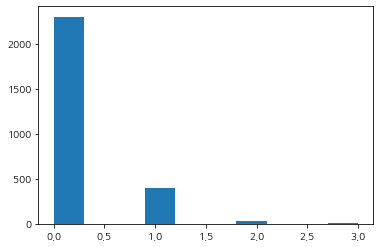

In [47]:
plt.hist(train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])
plt.show()

In [48]:
# 결측치 채워야할 row들 추출
nan_train = train.loc[train["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].isnull(),:]
print(f"nan_train.shape : {nan_train.shape}")
nan_train.head()

nan_train.shape : (211, 15)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
94,C1312,518,아파트,충청남도,국민임대,39.72,60,12.0,A,17460000,122210,NaN,3.0,527.0,359.0
95,C1312,518,아파트,충청남도,국민임대,39.98,89,12.0,A,17460000,122210,NaN,3.0,527.0,359.0
96,C1312,518,아파트,충청남도,국민임대,41.55,225,12.0,A,19954000,130940,NaN,3.0,527.0,359.0
97,C1312,518,아파트,충청남도,국민임대,46.90,143,12.0,A,28687000,149660,NaN,3.0,527.0,359.0
98,C1874,619,아파트,충청남도,영구임대,26.37,294,2.0,C,3141000,69900,NaN,2.0,97.0,62.0


In [49]:
# 결측치 채워야할 row들 추출
nan_test = test.loc[test["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].isnull(),:]
print(f"nan_test.shape : {nan_test.shape}")
nan_test.head()

nan_test.shape : (42, 14)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
68,C1472,548,아파트,충청남도,국민임대,36.62,116,2.0,A,8738000,87380,NaN,1.0,442.0
69,C1472,548,아파트,충청남도,국민임대,39.51,56,2.0,A,9985000,99850,NaN,1.0,442.0
70,C1472,548,아파트,충청남도,국민임대,46.79,56,2.0,A,13731000,131070,NaN,1.0,442.0
71,C1472,548,아파트,충청남도,국민임대,46.90,86,2.0,A,13731000,131070,NaN,1.0,442.0
72,C1472,548,아파트,충청남도,국민임대,51.93,234,2.0,A,18726000,143550,NaN,1.0,442.0


In [50]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


100%|██████████| 4/4 [00:00<00:00, 176.45it/s]


임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train.shape : (2741, 53)
preprocessed_train_nan.shape : (211, 53)
preprocessed_df_test.shape : (42, 53)
Model Name : LGBMRegressor
accuracy_score : 1.0
mean_absolute_error : 0.0028875470375953707 & mean_squared_error(root) : 0.00499530262519703
      0    1   2  3
0  2302    0   0  0
1     0  400   0  0
2     0    0  33  0
3     0    0   0  6


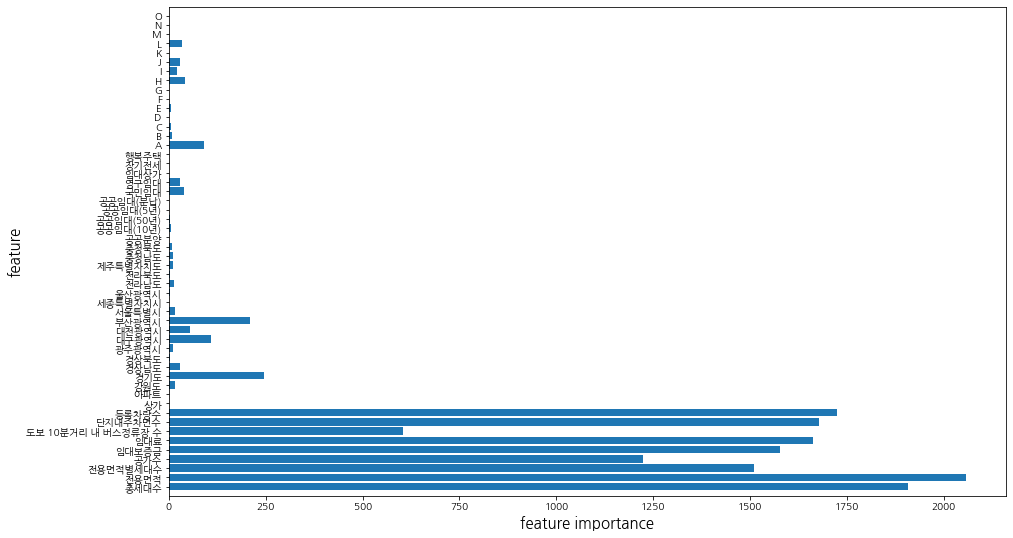

In [51]:
# RandomForest로 `도보 10분거리 내 지하철역 수(환승노선 수 반영)` 변수의 결측치를 한번 채워보자

def process_for_imputation_modleing3(df, df_test, impute_train=True):
    if impute_train:
        df = df.copy()
        pass
    else:
        df = df.drop(['등록차량수'],axis=1).copy()
    
    df['belongs'] = 'train'
    df_test['belongs'] = 'test'
    df = pd.concat([df,df_test],axis=0)
    df.index = range(df.shape[0])

    preprocessed_df = df.copy().drop(['단지코드'],axis=1)
    preprocessed_df['nan_in_target'] = False
    preprocessed_df.loc[preprocessed_df['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull(),"nan_in_target"] = True

    preprocessed_df = preprocessed_df.fillna(-999)
    preprocessed_df = preprocessed_df.replace('-',-999)
    preprocessed_df[['임대보증금', '임대료']] = preprocessed_df[['임대보증금', '임대료']].astype('float')

    cat_features = [col for col in preprocessed_df.columns if (preprocessed_df[col].dtype=='O') & (col not in ['belongs','nan_in_target'])]

    for c in tqdm(cat_features):
        dummy_df_for_cat = pd.get_dummies(preprocessed_df[c])
        print(f"{c} 변수 더미차원추가 : {dummy_df_for_cat.shape[1]}")
        preprocessed_df = pd.concat([preprocessed_df,dummy_df_for_cat],axis=1).drop([c],axis=1)
    
    preprocessed_df_test = preprocessed_df.loc[preprocessed_df['belongs']=="test",:].drop(['belongs'],axis=1).drop(['nan_in_target'],axis=1)
    preprocessed_df_test.index = range(preprocessed_df_test.shape[0])

    preprocessed_df = preprocessed_df.loc[preprocessed_df['belongs']=="train",:].drop(['belongs'],axis=1)
    preprocessed_train_nan = preprocessed_df.loc[preprocessed_df["nan_in_target"]==True,:].drop(['nan_in_target'],axis=1)
    preprocessed_train = preprocessed_df.loc[preprocessed_df["nan_in_target"]==False,:].drop(['nan_in_target'],axis=1)

    return preprocessed_train, preprocessed_train_nan, preprocessed_df_test

preprocessed_train, preprocessed_train_nan, preprocessed_df_test = process_for_imputation_modleing3(train, nan_test, impute_train=True)
print(f"preprocessed_train.shape : {preprocessed_train.shape}")
print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error # 정확도 함수
train_x = preprocessed_train.drop(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'],axis=1)
train_y = preprocessed_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)']

# RF
# model_for_imputation = RandomForestRegressor(n_estimators=500,random_state=seed)
# LGBM
model_for_imputation = LGBMRegressor(n_estimators=500,random_state=seed)


model_for_imputation.fit(train_x,train_y)

predict_result = model_for_imputation.predict(train_x)
print('='*50)
model_name = str(model_for_imputation)
print(f"Model Name : {model_name[:model_name.index('(')]}")
print(f"accuracy_score : {accuracy_score(train_y,np.round(predict_result))}")
print(f"mean_absolute_error : {mean_absolute_error(train_y,predict_result)} & mean_squared_error(root) : {mean_squared_error(train_y,predict_result)**0.5}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
cfm = confusion_matrix(y_true=train_y, y_pred=np.round(predict_result))
cfm = pd.DataFrame(cfm, index=range(cfm.shape[0]),columns=range(cfm.shape[0]))
print(cfm)
print('='*50)

## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.figure(figsize=(15,9))
plt.barh(index, model_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

# Model Name : RandomForestRegressor
# accuracy_score : 1.0
# mean_absolute_error : 0.003946005107624956 & mean_squared_error(root) : 0.018864829576896294

# Model Name : LGBMRegressor
# accuracy_score : 1.0
# mean_absolute_error : 0.0028875470375953707 & mean_squared_error(root) : 0.00499530262519703

In [52]:
from collections import Counter
## Train부터 `도보 10분거리 내 지하철역 수(환승노선 수 반영)` 변수 결측치 채우기 

print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
imput_val_by_model = np.round(model_for_imputation.predict(preprocessed_train_nan.drop(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'],axis=1)))
print(Counter(imput_val_by_model))
train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull(),'도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = imput_val_by_model
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

preprocessed_train_nan.shape : (211, 53)
Counter({0.0: 131, 1.0: 80})


0

100%|██████████| 4/4 [00:00<00:00, 146.40it/s]

임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train.shape : (2952, 52)
preprocessed_train_nan.shape : (0, 52)
preprocessed_df_test.shape : (42, 52)


Model Name : LGBMRegressor
accuracy_score : 1.0
mean_absolute_error : 0.004332974479281538 & mean_squared_error(root) : 0.008539550638386705
      0    1   2  3
0  2433    0   0  0
1     0  480   0  0
2     0    0  33  0
3     0    0   0  6


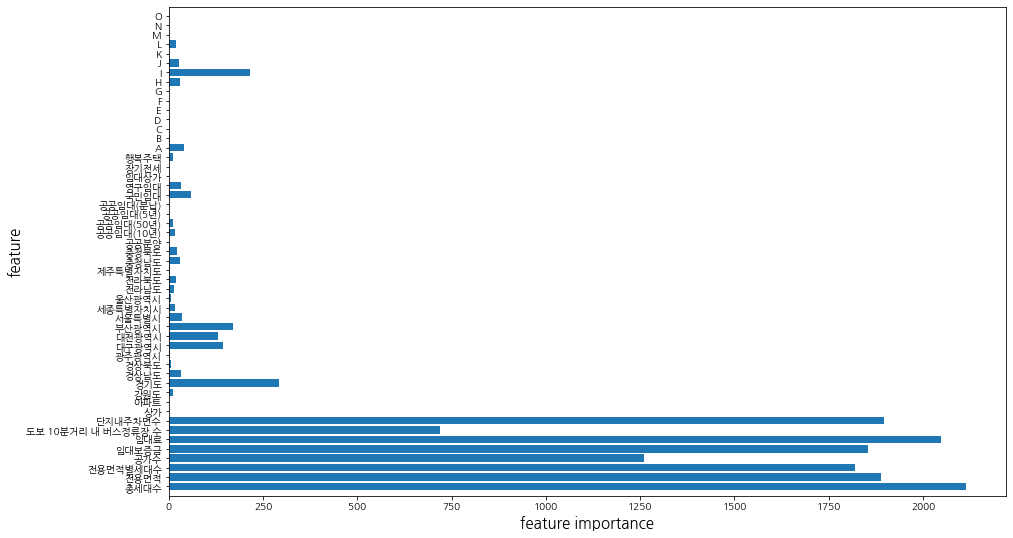

In [53]:
## Test Set `도보 10분거리 내 지하철역 수(환승노선 수 반영)` 변수 결측치 채우기
preprocessed_train, preprocessed_train_nan, preprocessed_df_test = process_for_imputation_modleing3(train, nan_test, impute_train=False)
print(f"preprocessed_train.shape : {preprocessed_train.shape}")
print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error # 정확도 함수
train_x = preprocessed_train.drop(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'],axis=1)
train_y = preprocessed_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)']

# RF
# model_for_imputation = RandomForestRegressor(n_estimators=500,random_state=seed)
# LGBM
model_for_imputation = LGBMRegressor(n_estimators=500,random_state=seed)


model_for_imputation.fit(train_x,train_y)

predict_result = model_for_imputation.predict(train_x)
print('='*50)
model_name = str(model_for_imputation)
print(f"Model Name : {model_name[:model_name.index('(')]}")
print(f"accuracy_score : {accuracy_score(train_y,np.round(predict_result))}")
print(f"mean_absolute_error : {mean_absolute_error(train_y,predict_result)} & mean_squared_error(root) : {mean_squared_error(train_y,predict_result)**0.5}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
cfm = confusion_matrix(y_true=train_y, y_pred=np.round(predict_result))
cfm = pd.DataFrame(cfm, index=range(cfm.shape[0]),columns=range(cfm.shape[0]))
print(cfm)
print('='*50)

## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.figure(figsize=(15,9))
plt.barh(index, model_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()


# Model Name : RandomForestRegressor
# accuracy_score : 1.0
# mean_absolute_error : 0.005120596205962061 & mean_squared_error(root) : 0.022019577394170993

# Model Name : LGBMRegressor
# accuracy_score : 1.0
# mean_absolute_error : 0.004332974479281538 & mean_squared_error(root) : 0.008539550638386705

In [54]:
from collections import Counter
## Train부터 `도보 10분거리 내 지하철역 수(환승노선 수 반영)` 변수 결측치 채우기 

print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")
imput_val_by_model = np.round(model_for_imputation.predict(preprocessed_df_test.drop(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'],axis=1)))
print(Counter(imput_val_by_model))
test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull(),'도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = imput_val_by_model
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

preprocessed_df_test.shape : (42, 52)
Counter({-0.0: 38, 1.0: 4})


0

###  0.4 임대료와 임대보증금 결측치

결측치로 NAN 뿐만 아니라 '-' 도 들어있음

임대료와 임대보증금에 존재하는 결측치들의 위치(인덱스)는 같음



※ 혹시 단지코드와 (임대료 & 임대보증금) 사이에 관계가 있을까?
- 두 변수 (임대료 & 임대보증금) 모두 관련이 있다. 결측치가 있는 코드단지 범주에 NaN이 아닌 다른 Value도 분포해있다.


In [55]:
print(all(train.loc[train['임대료'].isnull(),:].index==train.loc[train['임대보증금'].isnull(),:].index))
print(len(train.loc[train['임대료'].isnull(),:].index)==len(train.loc[train['임대보증금'].isnull(),:].index))

True
True


In [56]:
len(train.loc[train['임대료']=='-',:].index)

21

In [57]:
print(len(train.loc[train['임대료']=='-',:].index)==len(train.loc[train['임대보증금']=='-',:].index))
print(set(train.loc[train['임대보증금']=='-',:].index)-set(train.loc[train['임대료']=='-',:].index))

False
set()


In [58]:
unique_danji_codes = train.loc[train['임대료'].isnull(),'단지코드'].unique()
for U in unique_danji_codes:
    idxes = train.loc[train['단지코드'] == U,'임대료'].value_counts(dropna=False).index
    print(f"{U} : {idxes}")

C1925 : Index([nan, '144460', '130850'], dtype='object')
C1874 : Index([nan, '69900', '83020'], dtype='object')
C2416 : Index([nan, '80800', '69820'], dtype='object')
C2621 : Index([nan, '79980', '159960', '94990'], dtype='object')
C1616 : Index([nan, '28140', '79980', '94990'], dtype='object')
C1704 : Index([nan, '119190', '120370'], dtype='object')
C2258 : Index([nan, '122290', '79980', '94990'], dtype='object')
C2038 : Index([nan, '122290', '79980', '94990'], dtype='object')
C1859 : Index([nan, '79980', '94990', '159960'], dtype='object')
C1722 : Index([nan, '221030', '125000', '138130', '189240'], dtype='object')
C2190 : Index([nan, '69900', '83020'], dtype='object')
C1476 : Index([nan, '136000', '123200'], dtype='object')
C1983 : Index([nan, '145290', '149010', '124180', '142850'], dtype='object')
C2135 : Index([nan, '124390', '137660'], dtype='object')
C2034 : Index([nan, '124390', '137660'], dtype='object')
C1109 : Index([nan, '79980', '94990'], dtype='object')
C2289 : Index([na

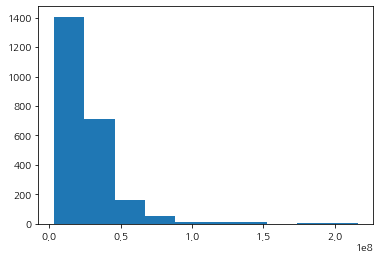

In [59]:
plt.hist(train.loc[train['임대보증금']!='-','임대보증금'].astype(float))
plt.show()

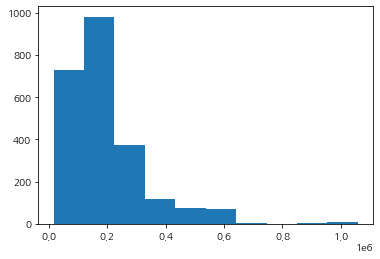

In [60]:
plt.hist(train.loc[train['임대료']!='-','임대료'].astype(float))
plt.show()

In [61]:
all(train.단지코드.apply(lambda x: x.startswith('C')))

True

In [62]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [63]:
copy_train = train.loc[train['임대료']!='-',:].copy()
copy_train['임대료'] = copy_train['임대료'].astype('float')
copy_train['단지코드'] = copy_train['단지코드'].apply(lambda x: str(x)[1:])
max_groupby_danji = copy_train.groupby(['단지코드'])['임대료'].max()
print('='*50)
print('C'+max_groupby_danji.index[max_groupby_danji.argmax()])
print(max_groupby_danji.max())

print('='*50)
copy_train['임대보증금'] = copy_train['임대보증금'].astype('float')
max_groupby_danji = copy_train.groupby(['단지코드'])['임대보증금'].max()
print('C'+max_groupby_danji.index[max_groupby_danji.argmax()])
print(max_groupby_danji.max())

C1024
1058030.0
C2357
194080000.0


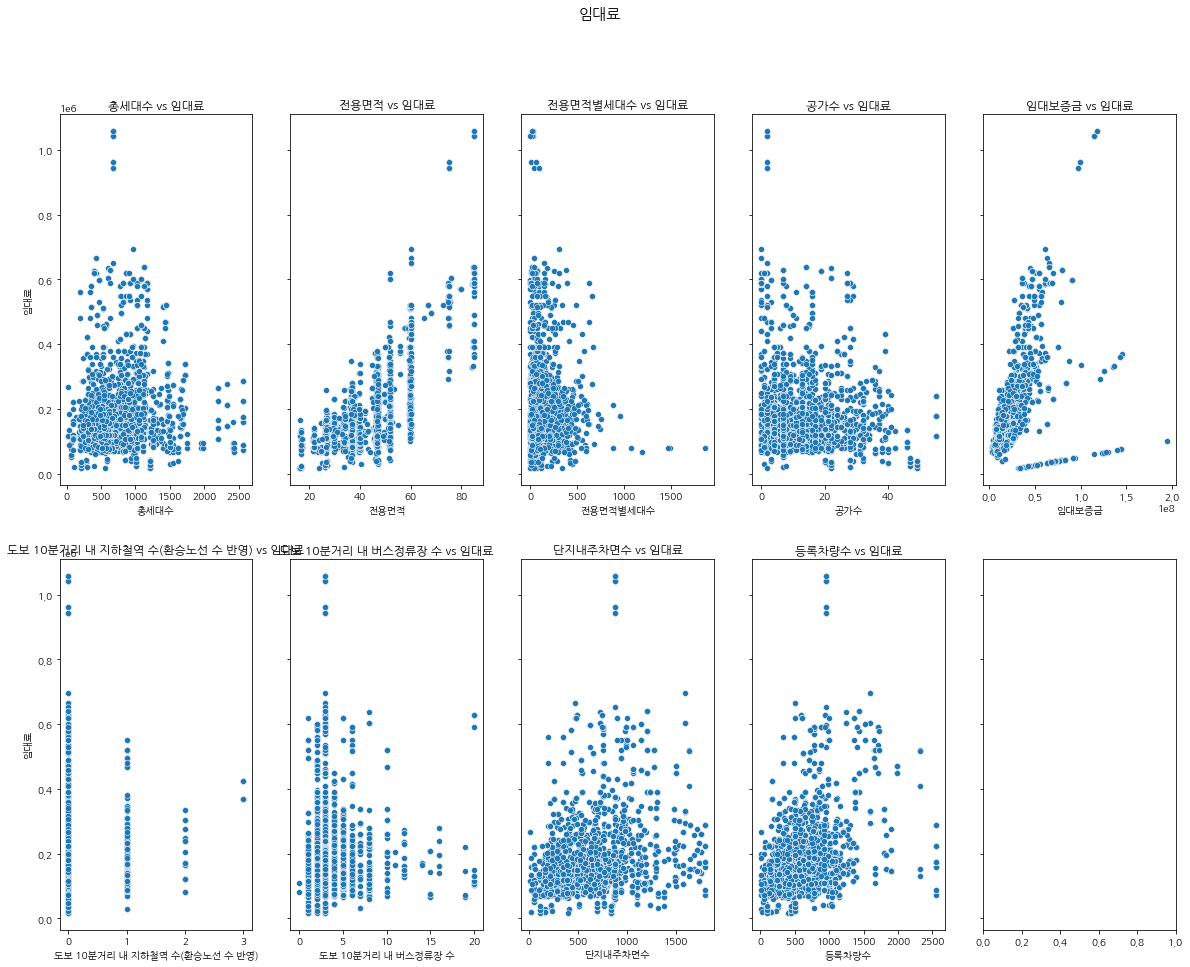

In [64]:
# Scatter Plot : 임대료 vs Continuous Variables
continuous_features = [c for c in copy_train.columns if (c not in ['임대료']) and (copy_train[c].dtype!='O')]

# feat = continuous_features[0]
max_col = len(continuous_features)//2+1 if len(continuous_features)%2!=0 else len(continuous_features)//2
fig, axes = plt.subplots(2, max_col, figsize=(20, 15), sharey=True)
fig.suptitle('임대료',fontsize=15)

for idx in range(len(continuous_features)):
    feat = continuous_features[idx]
    row_idx = idx//axes.shape[1]
    col_idx = idx%axes.shape[1]
    sns.scatterplot(ax=axes[row_idx][col_idx], x=copy_train[feat], y=copy_train['임대료'])
    axes[row_idx][col_idx].set_title(f"{feat} vs 임대료")

plt.show()


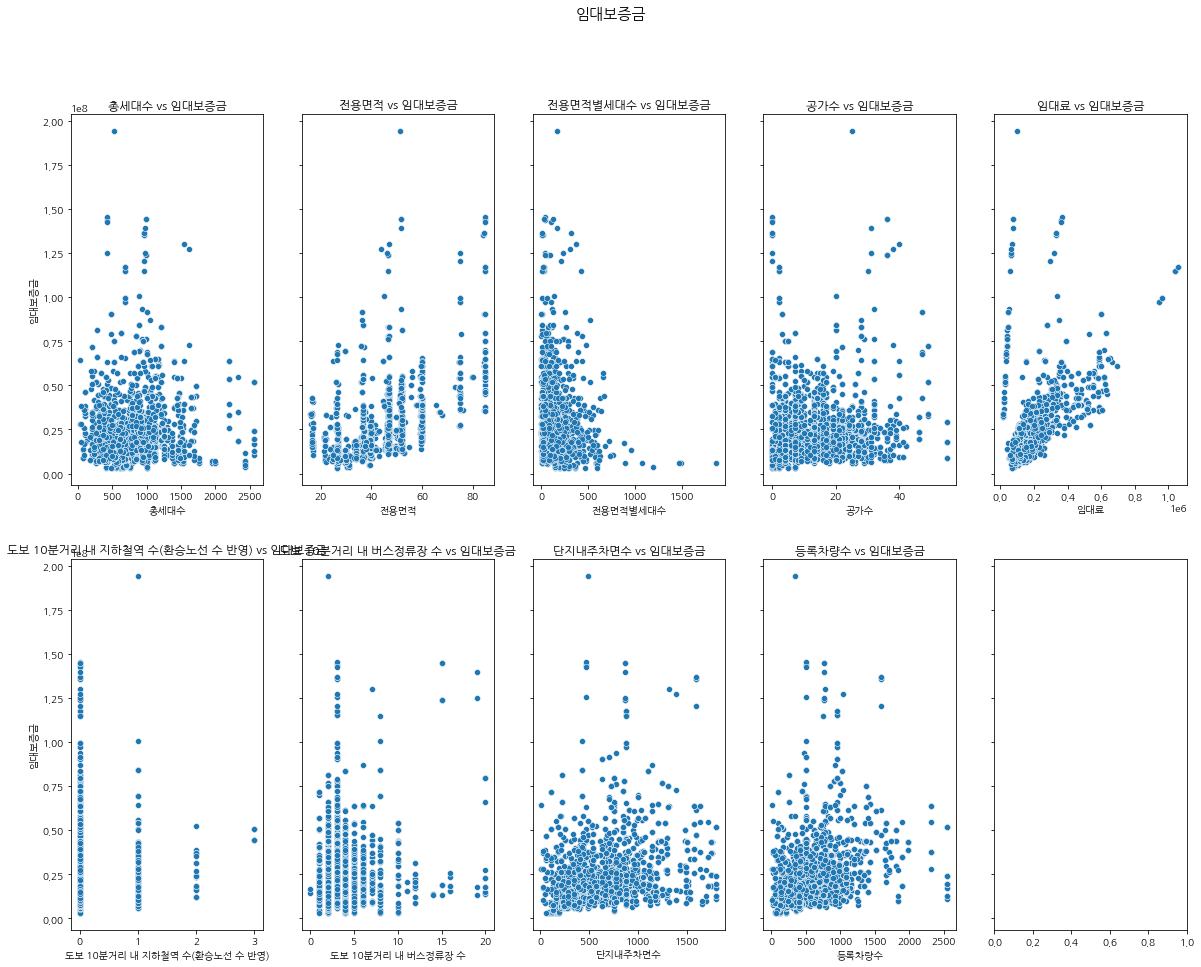

In [65]:
# Scatter Plot : 임대보증금 vs Continuous Variables
continuous_features = [c for c in copy_train.columns if (c not in ['임대보증금']) and (copy_train[c].dtype!='O')]

# feat = continuous_features[0]
max_col = len(continuous_features)//2+1 if len(continuous_features)%2!=0 else len(continuous_features)//2
fig, axes = plt.subplots(2, max_col, figsize=(20, 15), sharey=True)
fig.suptitle('임대보증금',fontsize=15)

for idx in range(len(continuous_features)):
    feat = continuous_features[idx]
    row_idx = idx//axes.shape[1]
    col_idx = idx%axes.shape[1]
    sns.scatterplot(ax=axes[row_idx][col_idx], x=copy_train[feat], y=copy_train['임대보증금'])
    axes[row_idx][col_idx].set_title(f"{feat} vs 임대보증금")

plt.show()

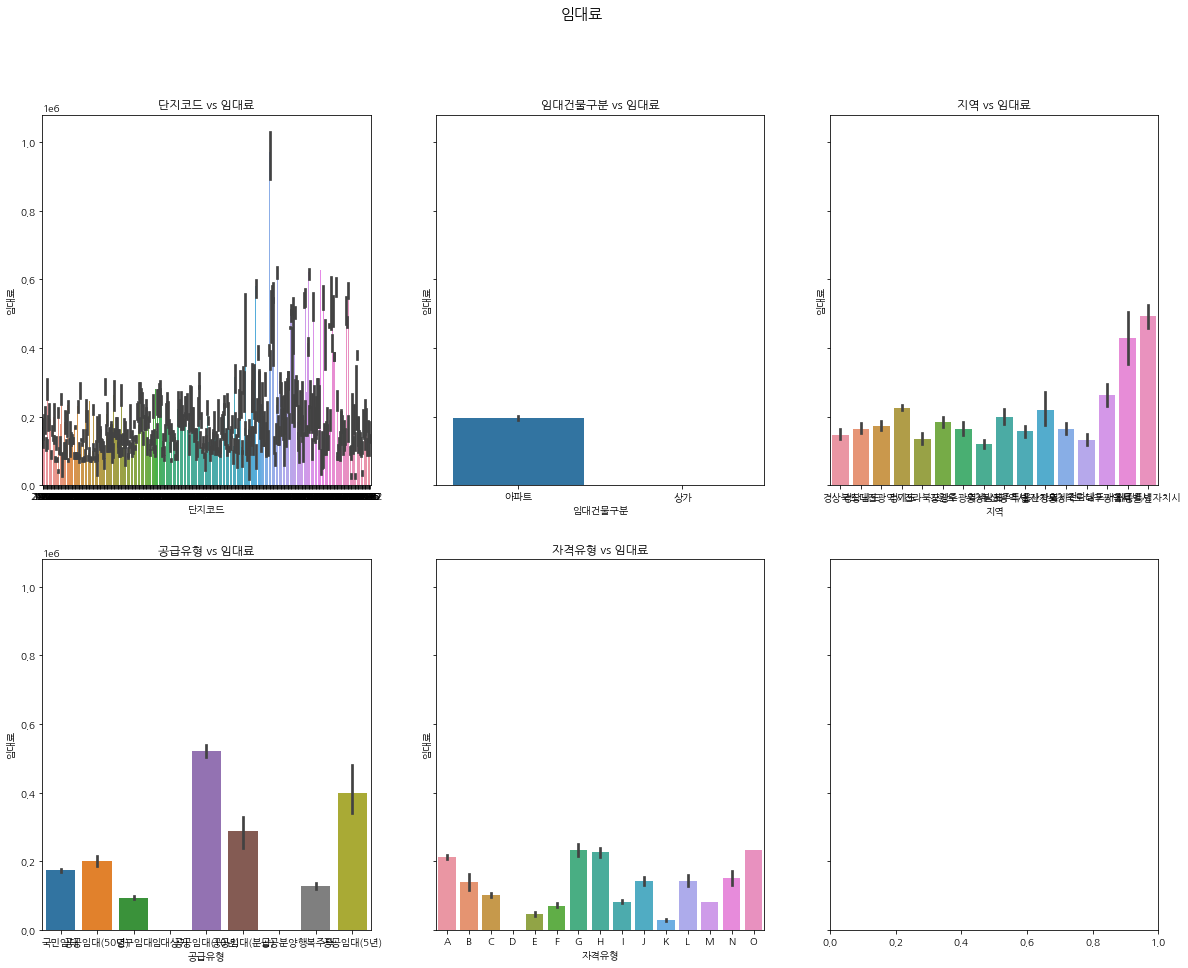

In [66]:
# Scatter Plot : 임대료 vs Categorical Variables
categorical_features = [c for c in copy_train.columns if (c not in ['임대료']) and (copy_train[c].dtype=='O')]

# feat = categorical_features[0]
max_col = len(categorical_features)//2+1 if len(categorical_features)%2!=0 else len(categorical_features)//2
fig, axes = plt.subplots(2, max_col, figsize=(20, 15), sharey=True)
fig.suptitle('임대료',fontsize=15)

for idx in range(len(categorical_features)):
    feat = categorical_features[idx]
    row_idx = idx//axes.shape[1]
    col_idx = idx%axes.shape[1]
    sns.barplot(ax=axes[row_idx][col_idx], x=copy_train[feat], y=copy_train['임대료'])
    axes[row_idx][col_idx].set_title(f"{feat} vs 임대료")

plt.show()

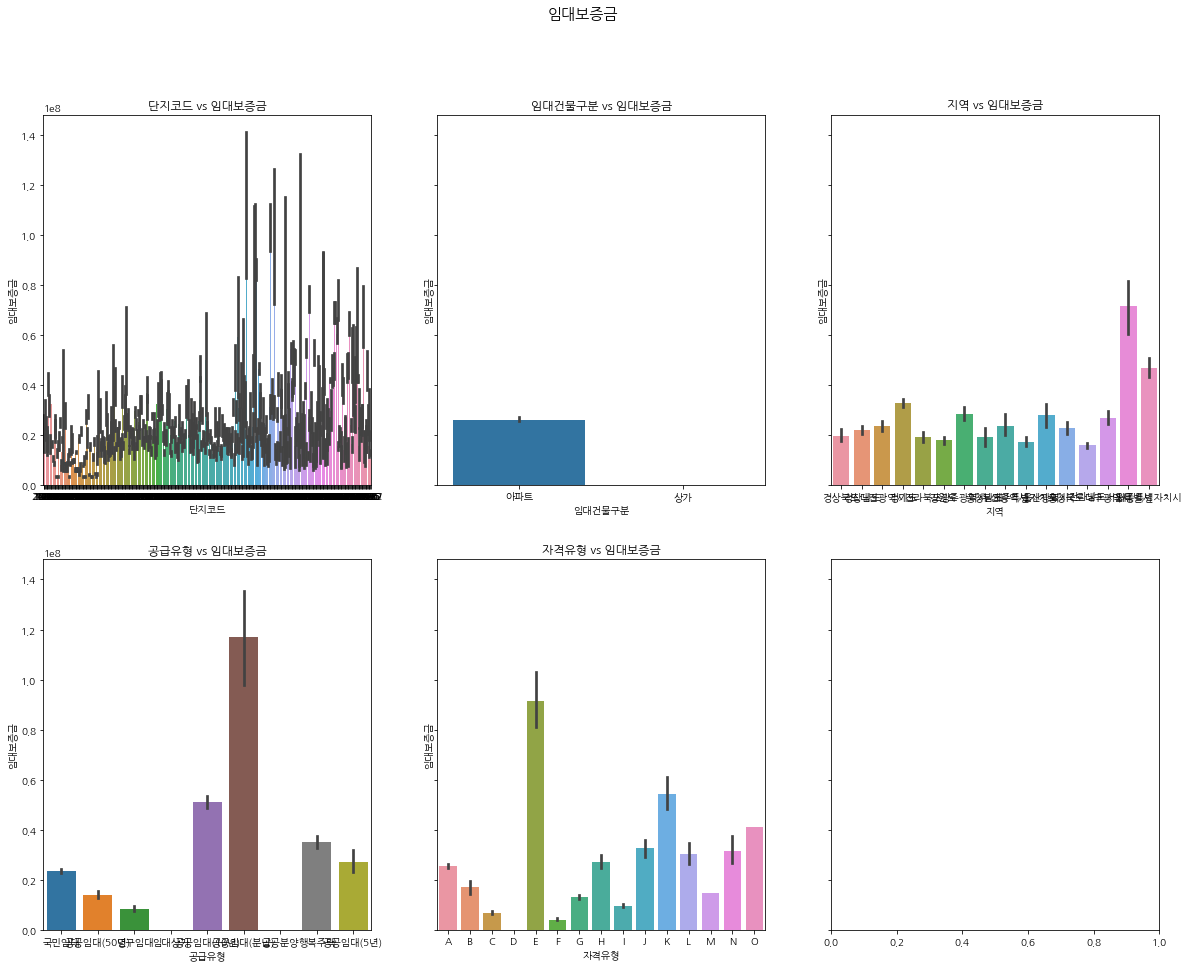

In [67]:
# Scatter Plot : 임대보증금 vs Categorical Variables
categorical_features = [c for c in copy_train.columns if (c not in ['임대보증금']) and (copy_train[c].dtype=='O')]

# feat = categorical_features[0]
max_col = len(categorical_features)//2+1 if len(categorical_features)%2!=0 else len(categorical_features)//2
fig, axes = plt.subplots(2, max_col, figsize=(20, 15), sharey=True)
fig.suptitle('임대보증금',fontsize=15)

for idx in range(len(categorical_features)):
    feat = categorical_features[idx]
    row_idx = idx//axes.shape[1]
    col_idx = idx%axes.shape[1]
    sns.barplot(ax=axes[row_idx][col_idx], x=copy_train[feat], y=copy_train['임대보증금'])
    axes[row_idx][col_idx].set_title(f"{feat} vs 임대보증금")

plt.show()

In [68]:
print([element for element in train.임대보증금.unique() if not str(element).isdigit()])
print([element for element in test.임대보증금.unique() if not str(element).isdigit()])

[nan, '-']
[nan, '-']


In [69]:
print([element for element in train.임대료.unique() if not str(element).isdigit()])
print([element for element in test.임대료.unique() if not str(element).isdigit()])

[nan, '-']
[nan, '-']


In [70]:
print(len(train['임대보증금']))
print(train['임대보증금'].isnull().sum())
print(train['임대료'].isnull().sum())

2952
569
569


In [71]:
print((train['임대보증금']=='-').sum())
print((train['임대료']=='-').sum())

12
21


#### ( *주의*  ) 개인적인 견해

> '-'로 채워져있는 결측치와 Nan(빈칸)으로 작성되어있는 결측치의 성질이 같을까?
- '-'로 채워져있는 부분은 아마 0으로 대체해야하지 않을까?

#### 우선, 아래 코드에서는 '-'부분만 0으로 채우고, Nan은 모델을 활용해 Inputation 해줬음

<br></br>
`임대료` 변수의 NaN을 채우는 과정에서 `임대보증금` 변수를 활용하지 않고 결측치를 채워야 한다.
<br></br>
>다른 노트북에서 고려해볼만한 부분

1. Nan 까지 모두 0으로 채우기
2. '-' 까지 모두 모델의 예측으로 결측치 채우기
3. 임대보증금 변수와 임대료의 관계까지 고려해서 결측치 채워보기 (할수없는 방법으로 보이는데?)
4. 그냥 평균으로 채우거나, 최빈값, 중앙값 등으로 채워보기
    
    - 카테고리별로 나누어서, 해당 결측치 row가 속하는 집단의 대푯값으로 결측치 채워보기

In [72]:
train = train.replace('-',0)
test = test.replace('-',0)

In [73]:
train.임대료.value_counts(dropna=False)

NaN       569
0          21
390000     19
79980      18
100920     16
         ... 
129930      1
233010      1
209240      1
138280      1
239430      1
Name: 임대료, Length: 996, dtype: int64

In [74]:
[str(val) for val in train['임대료'].unique() if str(val).isalpha()]

['nan']

In [75]:
copy_train = train.dropna(axis=0).copy()
print(copy_train['임대료'].astype('float').describe())
print(copy_train['임대보증금'].astype('float').describe())

count    2.383000e+03
mean     1.939933e+05
std      1.310816e+05
min      0.000000e+00
25%      1.105000e+05
50%      1.609600e+05
75%      2.357400e+05
max      1.058030e+06
Name: 임대료, dtype: float64
count    2.383000e+03
mean     2.672904e+07
std      2.164313e+07
min      0.000000e+00
25%      1.441800e+07
50%      2.080000e+07
75%      3.245650e+07
max      2.164230e+08
Name: 임대보증금, dtype: float64


In [76]:
nan_test = test.loc[test['임대료'].isnull(),:]
nan_test

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,NaN,NaN,2.0,5.0,428.0
80,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,NaN,NaN,2.0,5.0,428.0
81,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,NaN,NaN,2.0,5.0,428.0
82,C1006,1505,상가,대전광역시,임대상가,37.26,1,27.0,D,NaN,NaN,2.0,5.0,428.0
83,C1006,1505,상가,대전광역시,임대상가,37.41,1,27.0,D,NaN,NaN,2.0,5.0,428.0
84,C1006,1505,상가,대전광역시,임대상가,37.41,1,27.0,D,NaN,NaN,2.0,5.0,428.0
85,C1006,1505,상가,대전광역시,임대상가,37.41,1,27.0,D,NaN,NaN,2.0,5.0,428.0
86,C1006,1505,상가,대전광역시,임대상가,37.49,1,27.0,D,NaN,NaN,2.0,5.0,428.0


100%|██████████| 5/5 [00:00<00:00, 111.19it/s]


단지코드 변수 더미차원추가 : 430
임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train.shape : (2383, 482)
preprocessed_train_nan.shape : (569, 482)
preprocessed_df_test.shape : (180, 482)
Model Name : RandomForestRegressor
accuracy_score : 0.0
mean_absolute_error : 5643.890243090942 & mean_squared_error(root) : 9996.432204010558


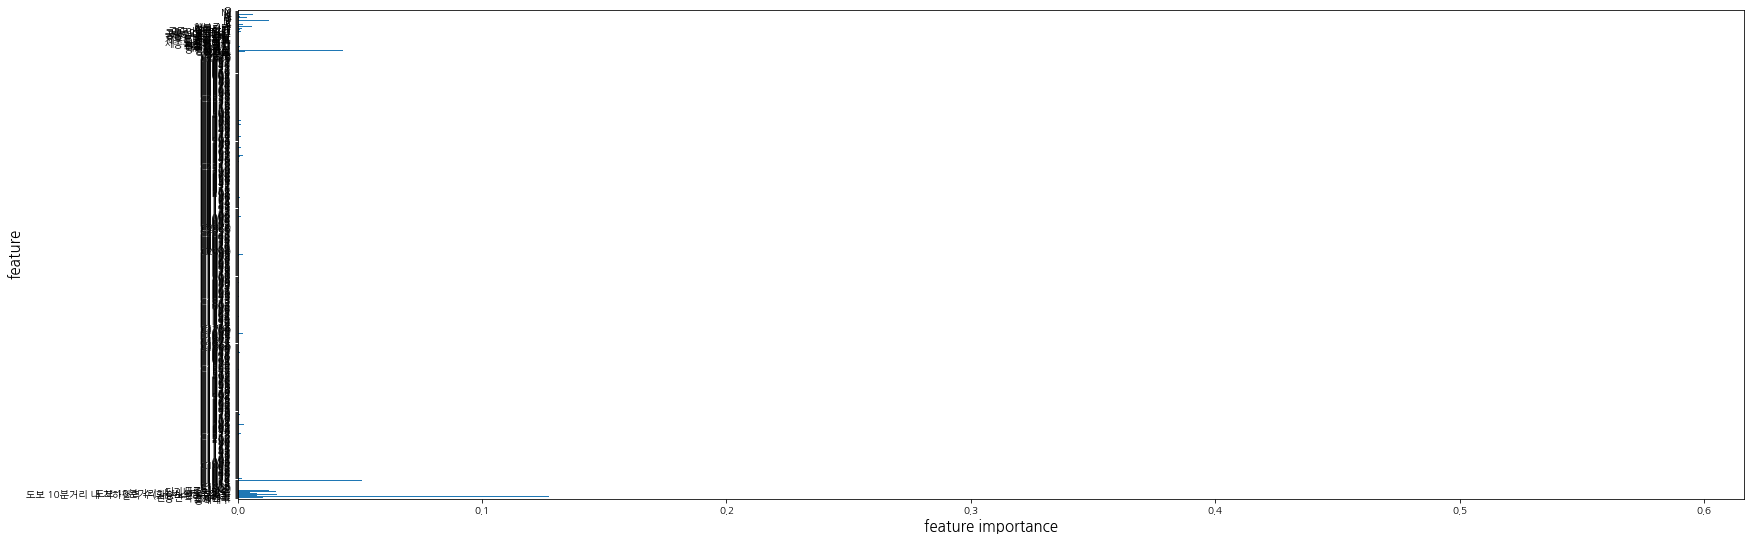

In [77]:
# ML Model로 `임대료` 변수의 결측치를 한번 채워보자

def process_for_imputation_modleing3(df, df_test, impute_train=True):
    if impute_train:
        df = df.copy()
    else:
        df = df.drop(['등록차량수'],axis=1)
    
    df['belongs'] = 'train'
    df_test['belongs'] = 'test'
    df = pd.concat([df,df_test],axis=0)
    df.index = range(df.shape[0])

    preprocessed_df = df.copy().drop(['임대보증금'],axis=1) # 단지코드 변수 사용하고, 임대보증금 사용안함 
    # preprocessed_df = df.copy().drop(['임대보증금','단지코드'],axis=1) # 단지코드 변수까지 사용안함 
    preprocessed_df['nan_in_target'] = False
    preprocessed_df.loc[preprocessed_df['임대료'].isnull(),"nan_in_target"] = True
    

    # preprocessed_df = preprocessed_df.fillna(-999)
    # preprocessed_df = preprocessed_df.replace('-',-999)
    preprocessed_df[['임대료']] = preprocessed_df[['임대료']].astype('float')

    cat_features = [col for col in preprocessed_df.columns if (preprocessed_df[col].dtype=='O') & (not col=='belongs')]

    for c in tqdm(cat_features):
        dummy_df_for_cat = pd.get_dummies(preprocessed_df[c])
        print(f"{c} 변수 더미차원추가 : {dummy_df_for_cat.shape[1]}")
        preprocessed_df = pd.concat([preprocessed_df,dummy_df_for_cat],axis=1).drop([c],axis=1)
    
    preprocessed_df_test = preprocessed_df.loc[preprocessed_df['belongs']=="test",:].drop(['belongs'],axis=1).drop(['nan_in_target'],axis=1)
    preprocessed_df_test.index = range(preprocessed_df_test.shape[0])

    preprocessed_df = preprocessed_df.loc[preprocessed_df['belongs']=="train",:].drop(['belongs'],axis=1)
    preprocessed_train_nan = preprocessed_df.loc[preprocessed_df["nan_in_target"]==True,:].drop(['nan_in_target'],axis=1)
    preprocessed_train = preprocessed_df.loc[preprocessed_df["nan_in_target"]==False,:].drop(['nan_in_target'],axis=1)

    return preprocessed_train, preprocessed_train_nan, preprocessed_df_test

preprocessed_train, preprocessed_train_nan, preprocessed_df_test = process_for_imputation_modleing3(train, nan_test, impute_train=True)
print(f"preprocessed_train.shape : {preprocessed_train.shape}")
print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error # 정확도 함수
train_x = preprocessed_train.drop(['임대료'],axis=1)
train_y = preprocessed_train['임대료']

# RF
model_for_imputation = RandomForestRegressor(n_estimators=1000,random_state=seed)
# LGBM
# model_for_imputation = LGBMRegressor(n_estimators=1000,random_state=seed)


model_for_imputation.fit(train_x,train_y)

predict_result = model_for_imputation.predict(train_x)
print('='*50)
model_name = str(model_for_imputation)
print(f"Model Name : {model_name[:model_name.index('(')]}")
print(f"accuracy_score : {accuracy_score(train_y,np.round(predict_result))}")
print(f"mean_absolute_error : {mean_absolute_error(train_y,predict_result)} & mean_squared_error(root) : {mean_squared_error(train_y,predict_result)**0.5}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
# cfm = confusion_matrix(y_true=train_y, y_pred=np.round(predict_result))
# cfm = pd.DataFrame(cfm, index=range(cfm.shape[0]),columns=range(cfm.shape[0]))
# print(cfm)
# print('='*50)

## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.figure(figsize=(27,9))
plt.barh(index, model_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

# Model Name : RandomForestRegressor
# accuracy_score : 0.000839278220730172
# mean_absolute_error : 5682.180670823092 & mean_squared_error(root) : 10027.693782708975

## with n_estimators=1000
# Model Name : RandomForestRegressor
# accuracy_score : 0.0
# mean_absolute_error : 5643.890243090942 & mean_squared_error(root) : 9996.432204010558


# Model Name : LGBMRegressor
# accuracy_score : 0.0
# mean_absolute_error : 2934.582300557903 & mean_squared_error(root) : 4338.545316214551

## with n_estimators=1000
# Model Name : LGBMRegressor
# accuracy_score : 0.0
# mean_absolute_error : 1190.5015009080464 & mean_squared_error(root) : 1758.8628180863861


In [78]:
from collections import Counter
## Train부터 `임대료` 변수 결측치 채우기 

print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
imput_val_by_model = model_for_imputation.predict(preprocessed_train_nan.drop(['임대료'],axis=1))
print(Counter(imput_val_by_model))
train.loc[train['임대료'].isnull(),'임대료'] = imput_val_by_model
train['임대료'].isnull().sum()

preprocessed_train_nan.shape : (569, 482)
Counter({135252.18: 14, 127712.19: 14, 98461.62: 14, 97106.82: 14, 90062.16: 12, 97973.32: 11, 98911.03: 10, 103471.47: 10, 107838.3: 9, 130616.78: 8, 131721.51: 8, 129579.83: 8, 95523.90071428572: 8, 105361.82: 8, 92455.14: 6, 104507.75: 6, 179808.89: 5, 133321.47: 5, 117501.57: 5, 210798.8: 5, 107670.84: 5, 195483.81: 5, 198904.22: 5, 134468.17: 5, 102940.62: 5, 94039.24571428572: 4, 99224.01: 4, 87687.934: 4, 109512.45: 4, 110253.35: 4, 94063.09: 4, 83919.465: 4, 95349.67571428571: 4, 95129.46571428572: 4, 113114.91: 4, 109958.27: 4, 110715.32: 4, 86930.48: 4, 219370.77: 4, 126052.92: 3, 87701.56: 3, 182778.02: 3, 153604.25: 3, 145481.11: 3, 158307.63: 3, 152450.13: 3, 131367.29: 3, 135156.79: 3, 131878.52: 3, 204542.12: 3, 124048.43: 3, 120724.15: 3, 131258.48: 3, 109724.53: 3, 131345.56: 3, 129944.11: 3, 83549.75: 2, 95004.7: 2, 120737.83: 2, 153230.9: 2, 153281.79: 2, 245690.94: 2, 90404.60071428571: 2, 94994.005: 2, 158028.78: 2, 158085.

0

100%|██████████| 5/5 [00:00<00:00, 87.60it/s]


단지코드 변수 더미차원추가 : 430
임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train.shape : (2952, 481)
preprocessed_train_nan.shape : (0, 481)
preprocessed_df_test.shape : (180, 481)
Model Name : RandomForestRegressor
mean_absolute_error : 4749.802162606954 & mean_squared_error(root) : 9263.223845169721


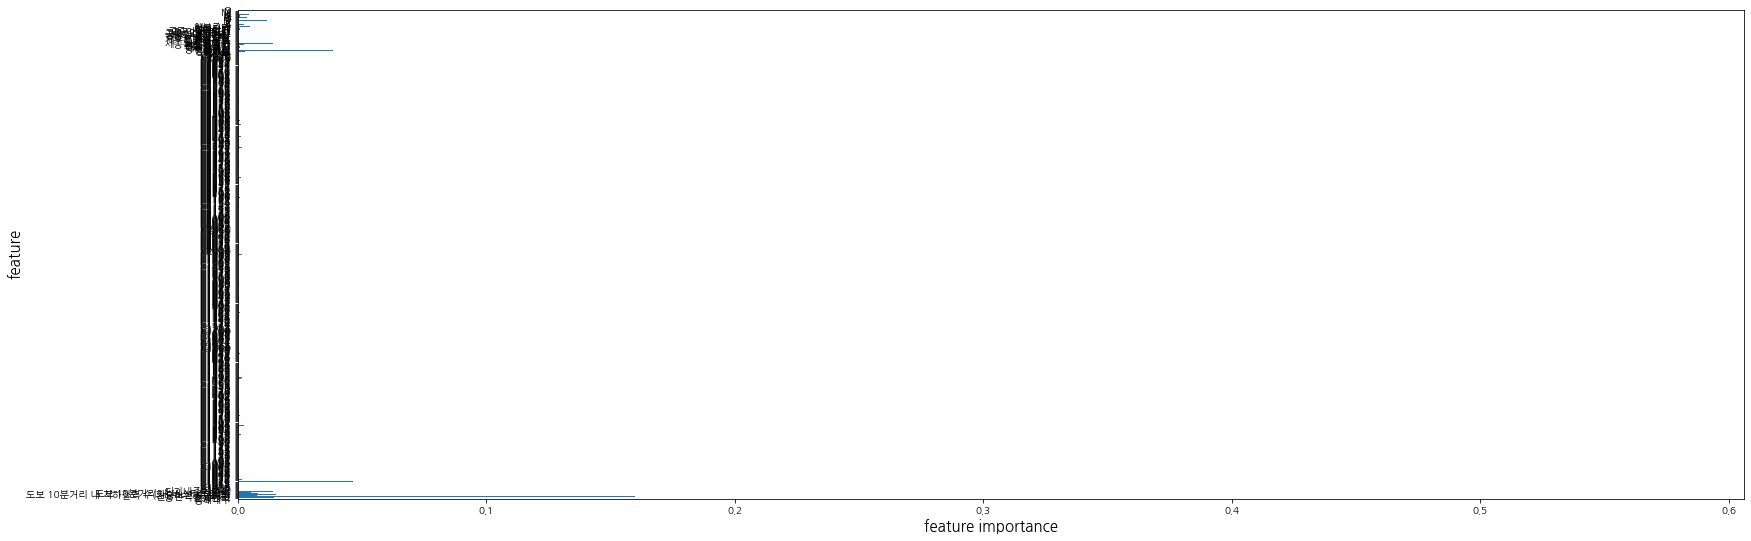

In [79]:
preprocessed_train, preprocessed_train_nan, preprocessed_df_test = process_for_imputation_modleing3(train, nan_test, impute_train=False)
print(f"preprocessed_train.shape : {preprocessed_train.shape}")
print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error # 정확도 함수
train_x = preprocessed_train.drop(['임대료'],axis=1)
train_y = preprocessed_train['임대료']

# RF
model_for_imputation = RandomForestRegressor(n_estimators=1000,random_state=seed)
# LGBM
# model_for_imputation = LGBMRegressor(n_estimators=1000,random_state=seed)


model_for_imputation.fit(train_x,train_y)

predict_result = model_for_imputation.predict(train_x)
print('='*50)
model_name = str(model_for_imputation)
print(f"Model Name : {model_name[:model_name.index('(')]}")
# print(f"accuracy_score : {accuracy_score(train_y,np.round(predict_result))}")
print(f"mean_absolute_error : {mean_absolute_error(train_y,predict_result)} & mean_squared_error(root) : {mean_squared_error(train_y,predict_result)**0.5}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
# cfm = confusion_matrix(y_true=train_y, y_pred=np.round(predict_result))
# cfm = pd.DataFrame(cfm, index=range(cfm.shape[0]),columns=range(cfm.shape[0]))
# print(cfm)
# print('='*50)

## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.figure(figsize=(27,9))
plt.barh(index, model_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

# Model Name : RandomForestRegressor
# accuracy_score : 0.000839278220730172
# mean_absolute_error : 5682.180670823092 & mean_squared_error(root) : 10027.693782708975

## with n_estimators=1000
# Model Name : RandomForestRegressor
# accuracy_score : 0.0
# mean_absolute_error : 5643.890243090942 & mean_squared_error(root) : 9996.432204010558


# Model Name : LGBMRegressor
# accuracy_score : 0.0
# mean_absolute_error : 2934.582300557903 & mean_squared_error(root) : 4338.545316214551


In [80]:
from collections import Counter
## Test `임대료` 변수 결측치 채우기 

print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")
imput_val_by_model = model_for_imputation.predict(preprocessed_df_test.drop(['임대료'],axis=1))
print(Counter(imput_val_by_model))
test.loc[test['임대료'].isnull(),'임대료'] = imput_val_by_model
test['임대료'].isnull().sum()

preprocessed_df_test.shape : (180, 481)
Counter({115170.53579399943: 9, 101404.95307000005: 7, 106227.04946599927: 6, 106151.77988800038: 5, 84369.10491928627: 4, 85061.05863571489: 4, 107689.15507542834: 4, 89433.89847800073: 4, 95566.71326614304: 4, 159994.22614999913: 3, 181057.61489999937: 3, 111425.72963000073: 3, 133351.12128000177: 3, 129857.02082999988: 3, 202612.7310800016: 3, 84378.38559971427: 2, 159494.3577900009: 2, 159522.59034000017: 2, 156234.9949499999: 2, 84992.84071228534: 2, 133619.35032000102: 2, 84190.13224928499: 2, 103354.62856571357: 2, 133612.28787999958: 2, 202593.9866200016: 2, 85662.13668542811: 2, 84765.94183571341: 2, 103482.2265499996: 2, 107379.82338000067: 2, 106911.2085464285: 2, 107011.76649757144: 2, 123365.29486485674: 2, 116705.79900000058: 2, 200251.72064000103: 2, 254520.46504999907: 2, 88883.11624900108: 2, 106158.0331480004: 2, 93988.2556957134: 2, 170853.28545999996: 1, 160223.06068999998: 1, 160024.66745000088: 1, 159447.2856500007: 1, 15517

0

#### 임대보증금 변수 결측치 채우기

In [81]:
nan_test = test.loc[test['임대보증금'].isnull(),:]
nan_test

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,84378.4,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,84378.4,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,NaN,170853,2.0,5.0,428.0
80,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,NaN,159494,2.0,5.0,428.0
81,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,NaN,159494,2.0,5.0,428.0
82,C1006,1505,상가,대전광역시,임대상가,37.26,1,27.0,D,NaN,160223,2.0,5.0,428.0
83,C1006,1505,상가,대전광역시,임대상가,37.41,1,27.0,D,NaN,159994,2.0,5.0,428.0
84,C1006,1505,상가,대전광역시,임대상가,37.41,1,27.0,D,NaN,159994,2.0,5.0,428.0
85,C1006,1505,상가,대전광역시,임대상가,37.41,1,27.0,D,NaN,159994,2.0,5.0,428.0
86,C1006,1505,상가,대전광역시,임대상가,37.49,1,27.0,D,NaN,160025,2.0,5.0,428.0


100%|██████████| 5/5 [00:00<00:00, 77.47it/s]


단지코드 변수 더미차원추가 : 430
임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train.shape : (2383, 482)
preprocessed_train_nan.shape : (569, 482)
preprocessed_df_test.shape : (180, 482)
Model Name : RandomForestRegressor
accuracy_score : 0.0
mean_absolute_error : 786934.1986451651 & mean_squared_error(root) : 1827286.8344648816


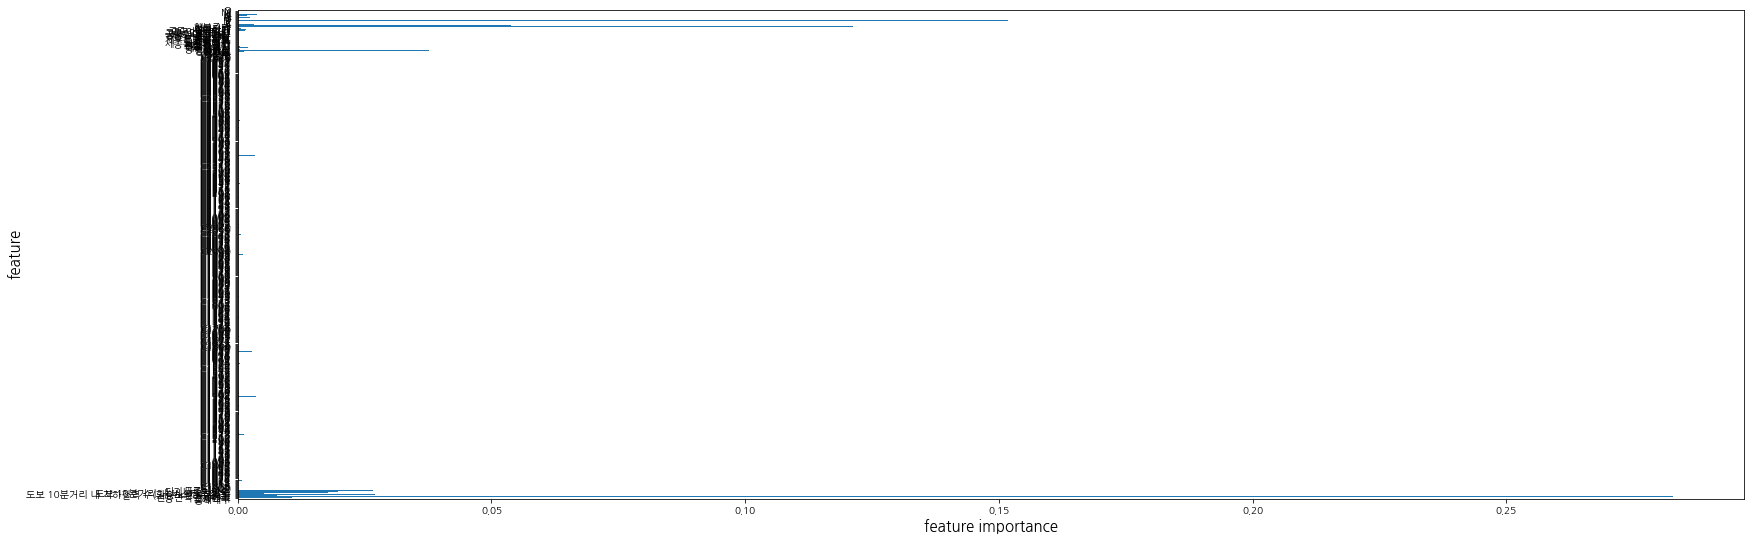

In [82]:
# ML Model로 `임대보증금` 변수의 결측치를 한번 채워보자

def process_for_imputation_modleing3(df, df_test, impute_train=True):
    if impute_train:
        df = df.copy()
    else:
        df = df.drop(['등록차량수'],axis=1)
    
    df['belongs'] = 'train'
    df_test['belongs'] = 'test'
    df = pd.concat([df,df_test],axis=0)
    df.index = range(df.shape[0])

    preprocessed_df = df.copy().drop(['임대료'],axis=1) # 단지코드 변수 사용하고, 임대보증금 사용안함 
    # preprocessed_df = df.copy().drop(['임대보증금','단지코드'],axis=1) # 단지코드 변수까지 사용안함 
    preprocessed_df['nan_in_target'] = False
    preprocessed_df.loc[preprocessed_df['임대보증금'].isnull(),"nan_in_target"] = True
    

    # preprocessed_df = preprocessed_df.fillna(-999)
    # preprocessed_df = preprocessed_df.replace('-',-999)
    preprocessed_df[['임대보증금']] = preprocessed_df[['임대보증금']].astype('float')

    cat_features = [col for col in preprocessed_df.columns if (preprocessed_df[col].dtype=='O') & (not col=='belongs')]

    for c in tqdm(cat_features):
        dummy_df_for_cat = pd.get_dummies(preprocessed_df[c])
        print(f"{c} 변수 더미차원추가 : {dummy_df_for_cat.shape[1]}")
        preprocessed_df = pd.concat([preprocessed_df,dummy_df_for_cat],axis=1).drop([c],axis=1)
    
    preprocessed_df_test = preprocessed_df.loc[preprocessed_df['belongs']=="test",:].drop(['belongs'],axis=1).drop(['nan_in_target'],axis=1)
    preprocessed_df_test.index = range(preprocessed_df_test.shape[0])

    preprocessed_df = preprocessed_df.loc[preprocessed_df['belongs']=="train",:].drop(['belongs'],axis=1)
    preprocessed_train_nan = preprocessed_df.loc[preprocessed_df["nan_in_target"]==True,:].drop(['nan_in_target'],axis=1)
    preprocessed_train = preprocessed_df.loc[preprocessed_df["nan_in_target"]==False,:].drop(['nan_in_target'],axis=1)

    return preprocessed_train, preprocessed_train_nan, preprocessed_df_test

preprocessed_train, preprocessed_train_nan, preprocessed_df_test = process_for_imputation_modleing3(train, nan_test, impute_train=True)
print(f"preprocessed_train.shape : {preprocessed_train.shape}")
print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error # 정확도 함수
train_x = preprocessed_train.drop(['임대보증금'],axis=1)
train_y = preprocessed_train['임대보증금']

# RF
model_for_imputation = RandomForestRegressor(n_estimators=1000,random_state=seed)
# LGBM
# model_for_imputation = LGBMRegressor(n_estimators=1000,random_state=seed)


model_for_imputation.fit(train_x,train_y)

predict_result = model_for_imputation.predict(train_x)
print('='*50)
model_name = str(model_for_imputation)
print(f"Model Name : {model_name[:model_name.index('(')]}")
print(f"accuracy_score : {accuracy_score(train_y,np.round(predict_result))}")
print(f"mean_absolute_error : {mean_absolute_error(train_y,predict_result)} & mean_squared_error(root) : {mean_squared_error(train_y,predict_result)**0.5}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
# cfm = confusion_matrix(y_true=train_y, y_pred=np.round(predict_result))
# cfm = pd.DataFrame(cfm, index=range(cfm.shape[0]),columns=range(cfm.shape[0]))
# print(cfm)
# print('='*50)

## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.figure(figsize=(27,9))
plt.barh(index, model_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

# n_estimators=1000
# Model Name : RandomForestRegressor
# accuracy_score : 0.0
# mean_absolute_error : 786934.1986451651 & mean_squared_error(root) : 1827286.8344648816


In [83]:
from collections import Counter
## Train부터 `임대보증금` 변수 결측치 채우기 

print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
imput_val_by_model = model_for_imputation.predict(preprocessed_train_nan.drop(['임대보증금'],axis=1))
print(Counter(imput_val_by_model))
train.loc[train['임대보증금'].isnull(),'임대보증금'] = imput_val_by_model
train['임대보증금'].isnull().sum()

preprocessed_train_nan.shape : (569, 482)
Counter({6435618.0: 18, 8168923.0: 14, 7301987.0: 14, 6586978.0: 14, 6291930.0: 14, 6408268.0: 12, 5213293.0: 11, 6709319.0: 10, 5196925.0: 10, 6676153.0: 9, 5322926.0: 9, 8079025.0: 8, 8559270.0: 8, 9791307.0: 8, 6287555.0: 8, 5765059.0: 7, 5248107.0: 6, 6628717.0: 6, 7076817.0: 5, 6598240.0: 5, 16601429.0: 5, 16362286.0: 5, 9307702.0: 5, 8530716.0: 5, 8357189.0: 5, 8405529.0: 5, 24116019.0: 5, 7012135.0: 5, 23413821.0: 5, 15405687.0: 5, 23221695.0: 5, 9202139.0: 5, 5475267.0: 5, 5379570.0: 5, 5246452.0: 5, 7106848.0: 4, 6604161.0: 4, 5077387.0: 4, 5083091.0: 4, 8373970.0: 4, 8445968.0: 4, 6441748.0: 4, 8376808.0: 4, 5160003.0: 4, 7362384.0: 4, 5389042.0: 4, 26669178.0: 4, 8737028.0: 3, 5165821.0: 3, 5171169.0: 3, 13534326.0: 3, 14160642.0: 3, 17054099.0: 3, 15523351.0: 3, 16616205.0: 3, 9097671.0: 3, 11182349.0: 3, 11231682.0: 3, 6595274.0: 3, 12115253.0: 3, 11985274.0: 3, 12107310.0: 3, 8833891.0: 3, 13757751.0: 3, 15427833.0: 3, 9849010.0: 

0

100%|██████████| 5/5 [00:00<00:00, 131.61it/s]


단지코드 변수 더미차원추가 : 430
임대건물구분 변수 더미차원추가 : 2
지역 변수 더미차원추가 : 16
공급유형 변수 더미차원추가 : 10
자격유형 변수 더미차원추가 : 15
preprocessed_train.shape : (2952, 481)
preprocessed_train_nan.shape : (0, 481)
preprocessed_df_test.shape : (180, 481)
Model Name : RandomForestRegressor
accuracy_score : 0.05623306233062331
mean_absolute_error : 625296.9268326558 & mean_squared_error(root) : 1523973.7751911033


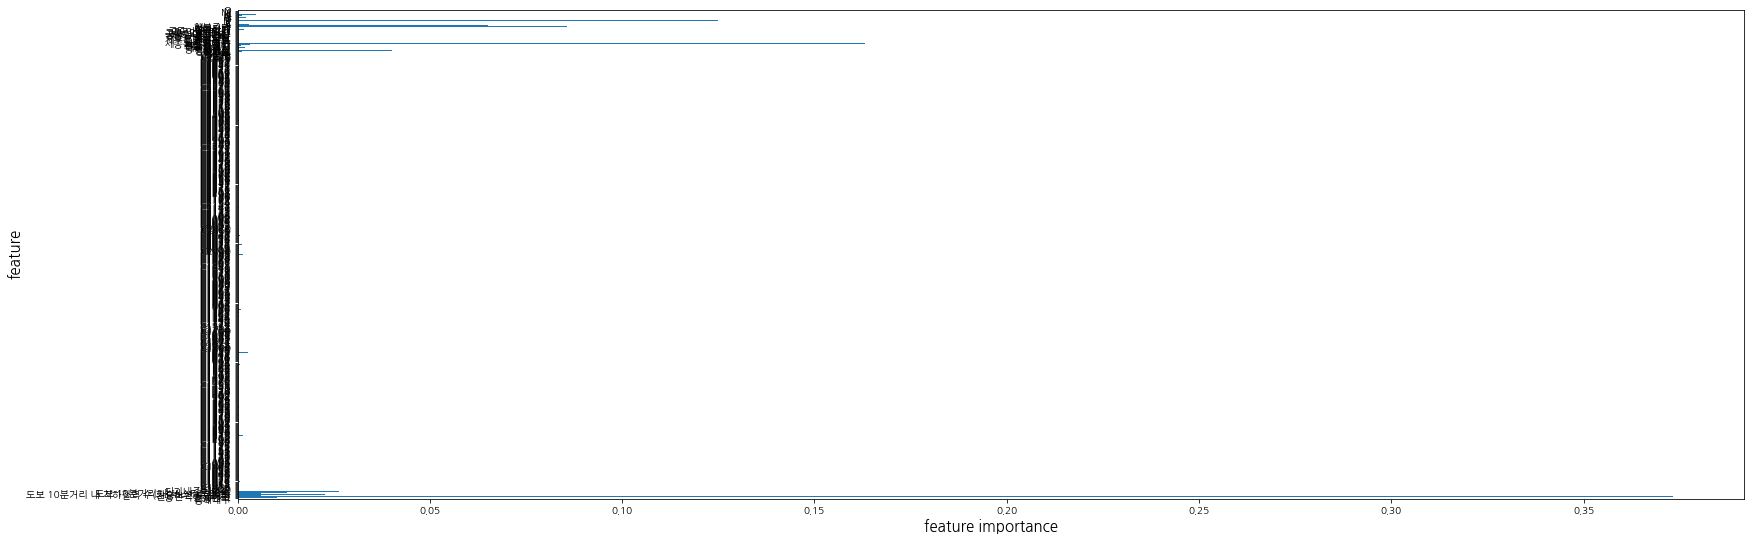

In [84]:
preprocessed_train, preprocessed_train_nan, preprocessed_df_test = process_for_imputation_modleing3(train, nan_test, impute_train=False)
print(f"preprocessed_train.shape : {preprocessed_train.shape}")
print(f"preprocessed_train_nan.shape : {preprocessed_train_nan.shape}")
print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error # 정확도 함수
train_x = preprocessed_train.drop(['임대보증금'],axis=1)
train_y = preprocessed_train['임대보증금']

# RF
model_for_imputation = RandomForestRegressor(n_estimators=1000,random_state=seed)
# LGBM
# model_for_imputation = LGBMRegressor(n_estimators=1000,random_state=seed)


model_for_imputation.fit(train_x,train_y)

predict_result = model_for_imputation.predict(train_x)
print('='*50)
model_name = str(model_for_imputation)
print(f"Model Name : {model_name[:model_name.index('(')]}")
print(f"accuracy_score : {accuracy_score(train_y,np.round(predict_result))}")
print(f"mean_absolute_error : {mean_absolute_error(train_y,predict_result)} & mean_squared_error(root) : {mean_squared_error(train_y,predict_result)**0.5}")
print('='*50)
## 결측치 채우는 모델의 Confusion Matrix
# cfm = confusion_matrix(y_true=train_y, y_pred=np.round(predict_result))
# cfm = pd.DataFrame(cfm, index=range(cfm.shape[0]),columns=range(cfm.shape[0]))
# print(cfm)
# print('='*50)

## 결측치 채우는 모델의 Feature Importance Plot
n_feature = train_x.shape[1]
index = np.arange(n_feature)

plt.figure(figsize=(27,9))
plt.barh(index, model_for_imputation.feature_importances_, align='center')
plt.yticks(index, train_x.columns)
plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

# n_estimators=1000
# Model Name : RandomForestRegressor
# accuracy_score : 0.0
# mean_absolute_error : 786934.1986451651 & mean_squared_error(root) : 1827286.8344648816

In [85]:
from collections import Counter
## Test `임대보증금` 변수 결측치 채우기 

print(f"preprocessed_df_test.shape : {preprocessed_df_test.shape}")
imput_val_by_model = model_for_imputation.predict(preprocessed_df_test.drop(['임대보증금'],axis=1))
print(Counter(imput_val_by_model))
test.loc[test['임대보증금'].isnull(),'임대보증금'] = imput_val_by_model
test['임대보증금'].isnull().sum()

preprocessed_df_test.shape : (180, 481)
Counter({6804884.269: 9, 6711429.83: 7, 5549850.93: 7, 5293603.516: 6, 5928819.625: 5, 23746881.249: 5, 7839527.553: 5, 5928816.94: 4, 5239373.047: 4, 7839581.557: 4, 5331180.438: 4, 13729928.134: 3, 18320410.65: 3, 9065140.932: 3, 13416302.225: 3, 14497953.124: 3, 6666534.149: 2, 14608329.592: 2, 14597550.954: 2, 16066240.81: 2, 14451302.939: 2, 5987098.447: 2, 14444539.631: 2, 5238600.956: 2, 5238607.006: 2, 5277400.582: 2, 7080595.29: 2, 7911163.872: 2, 9559419.636: 2, 17576468.096: 2, 45545991.647: 2, 5252726.781: 2, 5253314.309: 2, 5253332.401: 2, 5330491.964: 2, 16959310.074: 1, 13712397.599: 1, 13960522.211: 1, 14600248.41: 1, 14645739.774: 1, 18313983.704: 1, 18315367.33: 1, 39511127.31: 1, 45310455.329: 1, 5932747.938: 1, 5943023.776: 1, 6257083.34: 1, 6315358.52: 1, 8447203.749: 1, 8810253.68: 1, 8880477.068: 1, 13402502.528: 1, 13718607.448: 1, 14452450.597: 1, 15101384.962: 1, 42378197.086: 1, 48456697.647: 1, 48473244.792: 1, 5238635

0

In [86]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [87]:
print(train.shape)
train.tail(10)

(2952, 15)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2942,C2020,40,아파트,부산광역시,행복주택,16.80,20,7.0,L,18000000,87000,1.0,2.0,25.0,19.0
2943,C2020,40,아파트,부산광역시,행복주택,26.42,5,7.0,L,28000000,135330,1.0,2.0,25.0,19.0
2944,C2020,40,아파트,부산광역시,행복주택,36.63,15,7.0,L,38400000,185600,1.0,2.0,25.0,19.0
2945,C2437,90,아파트,충청북도,영구임대,24.83,90,12.0,C,10346000,107530,0.0,1.0,30.0,16.0
2946,C2532,239,아파트,강원도,국민임대,46.61,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2951,C2532,239,아파트,강원도,국민임대,54.95,19,7.0,A,14830000,151030,0.0,1.0,166.0,146.0


In [88]:
print(test.shape)
test.head()

(1022, 14)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [110]:
train[['임대료','임대보증금']] = train[['임대료','임대보증금']].astype('float')
test[['임대료','임대보증금']] = test[['임대료','임대보증금']].astype('float')

## 1.변수생성 (Feature Engineering)

### 1.1 age_gender_info 처리후 병합

In [111]:
age_gender_info = pd.read_csv('./data/age_gender_info.csv')
age_gender_info.shape

(16, 23)

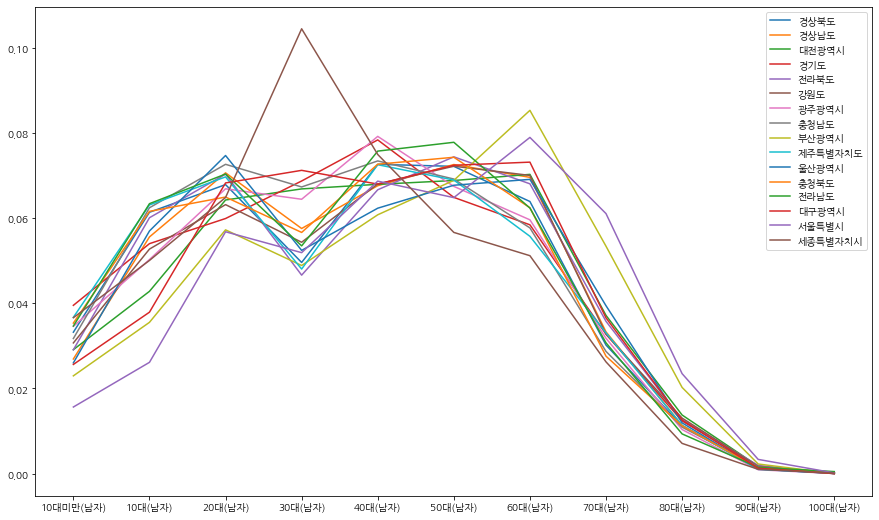

In [112]:
man_columns = [c for c in age_gender_info.columns if c.endswith('(남자)')]
man_age_gender_info = age_gender_info.set_index('지역')[man_columns]

plt.figure(figsize=(15,9))
for row_idx in man_age_gender_info.index:
    plt.plot(man_age_gender_info.columns, man_age_gender_info.loc[row_idx,:])
plt.legend(man_age_gender_info.index.tolist())
plt.show()


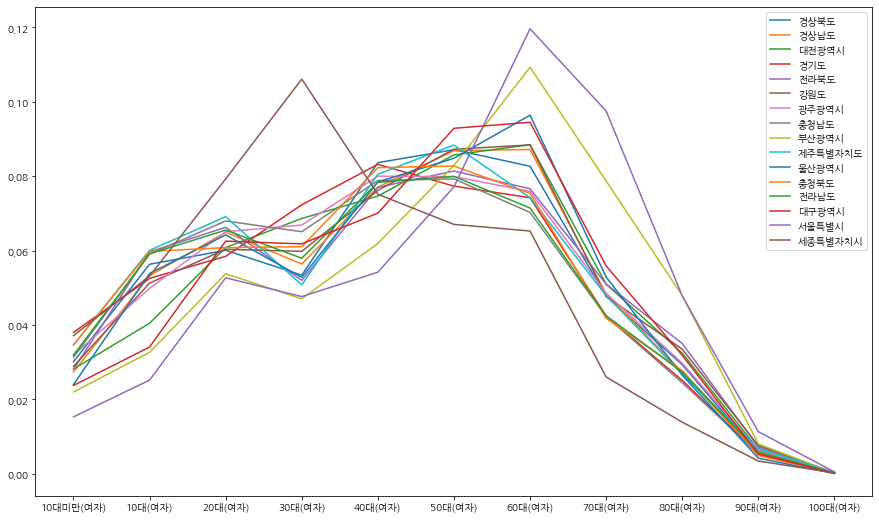

In [113]:
man_columns = [c for c in age_gender_info.columns if c.endswith('(여자)')]
man_age_gender_info = age_gender_info.set_index('지역')[man_columns]

plt.figure(figsize=(15,9))
for row_idx in man_age_gender_info.index:
    plt.plot(man_age_gender_info.columns, man_age_gender_info.loc[row_idx,:])
plt.legend(man_age_gender_info.index.tolist())
plt.show()


In [114]:
# # 모든 연령대, 성별에 대하여 통계량 도출
# origin_columns = [c for c in age_gender_info.columns if c!='지역']
# age_gender_info['모든연령대성별_지역별_인구비율_mean'] = age_gender_info[origin_columns].mean(axis=1)
# age_gender_info['모든연령대성별_지역별_인구비율_median'] = age_gender_info[origin_columns].median(axis=1)
# age_gender_info['모든연령대성별_지역별_인구비율_min'] = age_gender_info[origin_columns].min(axis=1)
# age_gender_info['모든연령대성별_지역별_인구비율_max'] = age_gender_info[origin_columns].max(axis=1)
# age_gender_info['모든연령대성별_지역별_인구비율_std'] = age_gender_info[origin_columns].std(axis=1)
## 모든연령대 : 남자, 여자 간의 통계량 차이값
# age_names_for_diff = ['10대미만'] + [f'{i}0대' for i in range(1,11)]

## (주요연령대) 20대 ~ 80대 : 남자, 여자 간의 통계량 차이값
age_names_for_diff = [f'{i}0대' for i in range(2,9)]

for age in age_names_for_diff:
    c1, c2 = age+'(남자)', age+'(여자)'
    age_gender_info[f"{age}_성별_비율_차이"] = age_gender_info[c1]-age_gender_info[c2]
diff_gender_per_age = [age+'_성별_비율_차이' for age in age_names_for_diff]
age_gender_info['주요연령대_성별_비율_차이_sum'] = age_gender_info[diff_gender_per_age].sum(axis=1)
age_gender_info['argmax_연령대_성별_비율_차이'] = age_gender_info[diff_gender_per_age].apply(lambda x: diff_gender_per_age[np.argmax(x)],axis=1)

# 주요연령대 & 성별 : 20대 ~ 80대까지 집중
main_age_man_names = [f'{i}0대(남자)' for i in range(2,9)]
main_age_woman_names = [f'{i}0대(여자)' for i in range(2,9)]
main_age_all_gender_names = main_age_man_names+main_age_woman_names

age_gender_info['argmax_연령대_남자'] = age_gender_info[main_age_man_names].apply(lambda x: main_age_man_names[np.argmax(x)],axis=1)
age_gender_info['argmax_연령대_여자'] = age_gender_info[main_age_woman_names].apply(lambda x: main_age_woman_names[np.argmax(x)],axis=1)

## 주요 연령대에 대하여 성별 나누어 통계량 도출
# 주요 연령대에 대하여 남자 통계량 도출
age_gender_info['주요연령대_남자_mean'] = age_gender_info[main_age_man_names].mean(axis=1)
age_gender_info['주요연령대_남자_median'] = age_gender_info[main_age_man_names].median(axis=1)
age_gender_info['주요연령대_남자_std'] = age_gender_info[main_age_man_names].std(axis=1)
age_gender_info['주요연령대_남자_max'] = age_gender_info[main_age_man_names].max(axis=1)
age_gender_info['주요연령대_남자_min'] = age_gender_info[main_age_man_names].min(axis=1)

# 주요 연령대에 대하여 여자 통계량 도출
age_gender_info['주요연령대_여자_mean'] = age_gender_info[main_age_woman_names].mean(axis=1)
age_gender_info['주요연령대_여자_median'] = age_gender_info[main_age_woman_names].median(axis=1)
age_gender_info['주요연령대_여자_std'] = age_gender_info[main_age_woman_names].std(axis=1)
age_gender_info['주요연령대_여자_max'] = age_gender_info[main_age_woman_names].max(axis=1)
age_gender_info['주요연령대_여자_min'] = age_gender_info[main_age_woman_names].min(axis=1)

# 주요 연령대에 대하여 모든성별 통계량 도출
age_gender_info['주요연령대_모든성별_mean'] = age_gender_info[main_age_all_gender_names].mean(axis=1)
age_gender_info['주요연령대_모든성별_median'] = age_gender_info[main_age_all_gender_names].median(axis=1)
age_gender_info['주요연령대_모든성별_std'] = age_gender_info[main_age_all_gender_names].std(axis=1)
age_gender_info['주요연령대_모든성별_max'] = age_gender_info[main_age_all_gender_names].max(axis=1)
age_gender_info['주요연령대_모든성별_min'] = age_gender_info[main_age_all_gender_names].min(axis=1)
print(age_gender_info.shape)
age_gender_info.head()

(16, 49)


,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),20대_성별_비율_차이,30대_성별_비율_차이,40대_성별_비율_차이,50대_성별_비율_차이,60대_성별_비율_차이,70대_성별_비율_차이,80대_성별_비율_차이,주요연령대_성별_비율_차이_sum,argmax_연령대_성별_비율_차이,argmax_연령대_남자,argmax_연령대_여자,주요연령대_남자_mean,주요연령대_남자_median,주요연령대_남자_std,주요연령대_남자_max,주요연령대_남자_min,주요연령대_여자_mean,주요연령대_여자_median,주요연령대_여자_std,주요연령대_여자_max,주요연령대_여자_min,주요연령대_모든성별_mean,주요연령대_모든성별_median,주요연령대_모든성별_std,주요연령대_모든성별_max,주요연령대_모든성별_min
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.018150,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.005697,0.001135,-0.009492,-0.014303,-0.017639,-0.015080,-0.016066,-0.065747,20대_성별_비율_차이,50대(남자),60대(여자),0.054639,0.067600,0.023491,0.072570,0.011295,0.064031,0.064920,0.021903,0.087201,0.027361,0.059335,0.066260,0.022358,0.087201,0.011295
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066,0.003413,-0.001806,-0.006743,-0.016931,-0.018207,-0.013867,-0.018704,-0.072845,20대_성별_비율_차이,60대(남자),60대(여자),0.055570,0.066848,0.021737,0.070261,0.013751,0.065977,0.068654,0.019806,0.088468,0.032455,0.060774,0.067386,0.020695,0.088468,0.013751
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067,0.001410,-0.003627,-0.004853,-0.012486,-0.015818,-0.009697,-0.012782,-0.057853,20대_성별_비율_차이,40대(남자),40대(여자),0.053616,0.059894,0.022976,0.078355,0.012354,0.061880,0.072331,0.021198,0.083208,0.025136,0.057748,0.062376,0.021667,0.083208,0.012354
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013,0.004060,-0.005431,-0.010361,-0.007026,-0.008594,-0.015277,-0.022408,-0.065037,20대_성별_비율_차이,50대(남자),50대(여자),0.053482,0.066645,0.022860,0.074382,0.012641,0.062773,0.066262,0.017206,0.081408,0.035049,0.058128,0.066454,0.020027,0.081408,0.012641


In [115]:
df = train[['단지코드','지역']].drop_duplicates().reset_index(drop=True)
df_test = test[['단지코드','지역']].drop_duplicates().reset_index(drop=True)

df = pd.merge(df,age_gender_info,on='지역')
df_test = pd.merge(df_test,age_gender_info,on='지역')
print(df.shape)
df.head()

(423, 50)


,단지코드,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),20대_성별_비율_차이,30대_성별_비율_차이,40대_성별_비율_차이,50대_성별_비율_차이,60대_성별_비율_차이,70대_성별_비율_차이,80대_성별_비율_차이,주요연령대_성별_비율_차이_sum,argmax_연령대_성별_비율_차이,argmax_연령대_남자,argmax_연령대_여자,주요연령대_남자_mean,주요연령대_남자_median,주요연령대_남자_std,주요연령대_남자_max,주요연령대_남자_min,주요연령대_여자_mean,주요연령대_여자_median,주요연령대_여자_std,주요연령대_여자_max,주요연령대_여자_min,주요연령대_모든성별_mean,주요연령대_모든성별_median,주요연령대_모든성별_std,주요연령대_모든성별_max,주요연령대_모든성별_min
0,C2483,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211
1,C2371,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211
2,C2097,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211
3,C1368,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211
4,C1057,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211


### 1.2 train & test feature enginnering

In [96]:
# 423개가 넘는 범주를 가지고 있다면, agg가 필요한 변수임
print(len(set(train['단지코드']))) 
print('='*50)
tr_nunique_groupby_danjicode = train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)
tr_nunique_groupby_danjicode

423


총세대수                             423
임대건물구분                           456
지역                               423
공급유형                             488
전용면적                            1898
전용면적별세대수                        2230
공가수                              423
자격유형                             510
임대보증금                           1476
임대료                             1526
도보 10분거리 내 지하철역 수(환승노선 수 반영)     423
도보 10분거리 내 버스정류장 수               423
단지내주차면수                          423
등록차량수                            423
dtype: int64

In [97]:
# 150개가 넘는 범주를 가지고 있다면, agg가 필요한 변수임
# train보다 unique하지 않은 column들이 더 많음 ('임대건물구분','공급유형','자격유형')
print(len(set(test['단지코드']))) 
print('='*50)
te_nunique_groupby_danjicode = test.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)
te_nunique_groupby_danjicode

150


총세대수                            150
임대건물구분                          157
지역                              150
공급유형                            167
전용면적                            693
전용면적별세대수                        797
공가수                             150
자격유형                            179
임대보증금                           554
임대료                             561
도보 10분거리 내 지하철역 수(환승노선 수 반영)    150
도보 10분거리 내 버스정류장 수              150
단지내주차면수                         150
dtype: int64

## 최종 Preprocessing

In [117]:
train.shape

(2952, 15)

In [118]:

def preprocess_merge(train, df, is_train):
    #### 1.1.0 Unique Columns
    unique_columns = set(tr_nunique_groupby_danjicode[tr_nunique_groupby_danjicode<=423].index) & set(te_nunique_groupby_danjicode[te_nunique_groupby_danjicode<=150].index)
    unique_columns = ['단지코드'] + list(unique_columns)
    print(unique_columns)
    if is_train:
        unique_columns += ['등록차량수']
    train_agg = train[unique_columns].drop_duplicates().reset_index(drop=True)
    print(train_agg.shape)

    #### 1.1.1 Continuous Features
    # agg가 필요한 연속형 변수들
    print('='*50)
    continuous_features_for_agg = ['전용면적','전용면적별세대수','임대료','임대보증금']

    is_train = True
    for continuous_feature in continuous_features_for_agg:
        cont_agg_dict_for_map = train.groupby(['단지코드'],as_index=False)[continuous_feature].agg(['count','sum','mean','std','max','min','median']).to_dict()

        train_agg[f"{continuous_feature}_count"] = train_agg['단지코드'].map(cont_agg_dict_for_map['count'])
        train_agg[f"{continuous_feature}_sum"] = train_agg['단지코드'].map(cont_agg_dict_for_map['sum'])
        train_agg[f"{continuous_feature}_mean"] = train_agg['단지코드'].map(cont_agg_dict_for_map['mean'])
        train_agg[f"{continuous_feature}_max"] = train_agg['단지코드'].map(cont_agg_dict_for_map['max'])
        train_agg[f"{continuous_feature}_min"] = train_agg['단지코드'].map(cont_agg_dict_for_map['min'])
        train_agg[f"{continuous_feature}_median"] = train_agg['단지코드'].map(cont_agg_dict_for_map['median'])
        train_agg[f"{continuous_feature}_std"] = train_agg['단지코드'].map(cont_agg_dict_for_map['std'])
        train_agg[f"{continuous_feature}_std"] = train_agg[f"{continuous_feature}_std"].fillna(0)
    print(train_agg.shape)
    # print({k:v for k,v in train_agg.isnull().sum().to_dict().items() if v!=0})

    #### 1.1.2 Categorical Features
    print('='*50)
    from collections import Counter
    from scipy.stats import mode    # 최빈값
    # agg가 필요한 범주형 변수들
    categorical_features_for_agg = ['임대건물구분','공급유형','자격유형']

    for categorical_feature in tqdm_notebook(categorical_features_for_agg):
        print(categorical_feature)
        # categorical_feature = '공급유형'    # '임대건물구분','공급유형','자격유형'

        counter_imdae_gunmul_gubun = train.groupby(['단지코드'])[categorical_feature].apply(lambda x: Counter(x))
        counter_imdae_gunmul_gubun = pd.DataFrame(
                                                    {
                                                    # '단지코드':[v1 for v1,v2 in counter_imdae_gunmul_gubun.index.tolist()],
                                                    categorical_feature:[v2 for v1,v2 in counter_imdae_gunmul_gubun.index.tolist()],
                                                    '개수':counter_imdae_gunmul_gubun.values,
                                                    },
                                                index = [v1 for v1,v2 in counter_imdae_gunmul_gubun.index.tolist()]
                                                ).fillna(0)

        uniques_in_categorical_feature = counter_imdae_gunmul_gubun[categorical_feature].unique()
        # print(uniques_in_categorical_feature)
        for category in uniques_in_categorical_feature:
            temp_for_map = counter_imdae_gunmul_gubun.loc[counter_imdae_gunmul_gubun[categorical_feature]==category,['개수']]
            temp_for_map = {k:v[0] for k,v in zip(temp_for_map.index,temp_for_map.values)}
            train_agg[f"{category}_count"] = train_agg['단지코드'].map(temp_for_map)
            count_cat_for_mode = [c+'_count' for c in uniques_in_categorical_feature]
        train_agg[f'argmax_cat_features_in_{categorical_feature}'] = train_agg[count_cat_for_mode].apply(lambda x: count_cat_for_mode[np.argmax(x)],axis=1)

    print(train_agg.shape)

    ### 1.3 Finally Merging
    print('='*50)
    print({k:v for k,v in df.isnull().sum().to_dict().items() if v!=0})
    print({k:v for k,v in train_agg.isnull().sum().to_dict().items() if v!=0})
    print('='*25)
    print(df.shape)
    print(train_agg.shape)
    final_df = df.merge(train_agg, on=['단지코드','지역'])
    print({k:v for k,v in final_df.isnull().sum().to_dict().items() if v!=0})
    print(final_df.shape)
    return final_df

final_df = preprocess_merge(train, df, True)
final_df_test = preprocess_merge(test, df_test, False)

['단지코드', '단지내주차면수', '총세대수', '지역', '도보 10분거리 내 버스정류장 수', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
(423, 8)
(423, 36)


임대건물구분
공급유형
자격유형

(423, 66)
{}
{}
(423, 50)
(423, 66)
{}
(423, 114)
['단지코드', '단지내주차면수', '총세대수', '지역', '도보 10분거리 내 버스정류장 수', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
(150, 7)
(150, 35)


임대건물구분
공급유형
자격유형

(150, 59)
{}
{}
(150, 50)
(150, 59)
{}
(150, 107)


In [120]:
print(final_df.shape)
print(final_df_test.shape)

(423, 114)
(150, 107)


In [126]:
final_df.head()

,단지코드,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),20대_성별_비율_차이,30대_성별_비율_차이,40대_성별_비율_차이,50대_성별_비율_차이,60대_성별_비율_차이,70대_성별_비율_차이,80대_성별_비율_차이,주요연령대_성별_비율_차이_sum,argmax_연령대_성별_비율_차이,argmax_연령대_남자,argmax_연령대_여자,주요연령대_남자_mean,주요연령대_남자_median,주요연령대_남자_std,주요연령대_남자_max,주요연령대_남자_min,주요연령대_여자_mean,주요연령대_여자_median,주요연령대_여자_std,주요연령대_여자_max,주요연령대_여자_min,주요연령대_모든성별_mean,주요연령대_모든성별_median,주요연령대_모든성별_std,주요연령대_모든성별_max,주요연령대_모든성별_min,단지내주차면수,총세대수,도보 10분거리 내 버스정류장 수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),등록차량수,전용면적_count,전용면적_sum,전용면적_mean,전용면적_max,전용면적_min,전용면적_median,전용면적_std,전용면적별세대수_count,전용면적별세대수_sum,전용면적별세대수_mean,전용면적별세대수_max,전용면적별세대수_min,전용면적별세대수_median,전용면적별세대수_std,임대료_count,임대료_sum,임대료_mean,임대료_max,임대료_min,임대료_median,임대료_std,임대보증금_count,임대보증금_sum,임대보증금_mean,임대보증금_max,임대보증금_min,임대보증금_median,임대보증금_std,아파트_count,상가_count,argmax_cat_features_in_임대건물구분,국민임대_count,영구임대_count,임대상가_count,공공임대(10년)_count,장기전세_count,행복주택_count,공공임대(분납)_count,공공분양_count,공공임대(50년)_count,공공임대(5년)_count,argmax_cat_features_in_공급유형,A_count,C_count,D_count,I_count,H_count,E_count,K_count,J_count,B_count,M_count,N_count,O_count,L_count,F_count,G_count,argmax_cat_features_in_자격유형
0,C2483,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211,1425.0,900,3.0,38.0,0.0,1015.0,8,399.01,49.87625,59.88,39.72,51.930,6.841349,8,900,112.500000,385,15,87.5,119.883277,8,1343280.0,167910.000000,214270.0,103680.0,184330.0,40967.438987,8,198211000.0,2.477638e+07,30357000.0,15667000.0,27304000.0,5.720255e+06,8.0,0.0,아파트_count,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,국민임대_count,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_count
1,C2371,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211,374.0,474,1.0,20.0,0.0,451.0,8,354.23,44.27875,51.93,36.52,46.900,6.666184,8,474,59.250000,134,22,44.0,41.842391,8,788130.0,98516.250000,123750.0,72080.0,108130.0,22826.622263,8,124835000.0,1.560438e+07,21868000.0,9731000.0,17302000.0,5.218119e+06,8.0,0.0,아파트_count,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,국민임대_count,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_count
2,C2097,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.007763,-0.003861,-0.011047,-0.015004,-0.018796,-0.017545,-0.01815,-0.076639,20대_성별_비율_차이,40대(남자),50대(여자),0.052495,0.063889,0.023692,0.072613,0.011211,0.063443,0.060096,0.021837,0.087149,0.029361,0.057969,0.061992,0.022615,0.087149,0.011211,1240.0,998,2.0,29.0,0.0,995.0,7,306.74,43.82000,59.61,33.80,39.990,8.279573,7,998,142.571429,244,88,122.0,53.191030,7,730610.0,104372.857143,228540.0,39840.0,110790.0,63345.615927,7,250779000.0,3.582557e+07,76506000.0,13158000.0,16737000.0,2.863207e+07,7.0,0.0,아파트_count,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,국민임대_count,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_count
3,C1368,경상북도,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.0

In [127]:
final_df.to_csv('./data/final_df.csv',index=False)
final_df_test.to_csv('./data/final_df_test.csv',index=False)

In [ ]:
not_exist_columns_in_test  = list(set(final_df.columns) - set(final_df_test.columns))
assert (final_df.shape[1]-final_df_test.shape[1] == len(not_exist_columns_in_test))
final_df.drop([n for n in not_exist_columns_in_test if n!='등록차량수'],axis=1)

## Modeling